In [3]:
import re
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================

CSV_FILE_PATH = '/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv'
PROPERTY_ID_COL = 'PROPERTY_ID'
COMMENTS_COL = 'PUBLIC_LISTING_COMMENTS'
PARSED_OUTPUT_COL = 'PARSED_OUTPUT'  # Column with image analysis data

# LDA Parameters
N_TOPICS = 10
N_TOP_WORDS = 15
MAX_FEATURES = 150
MIN_N = 2  # minimum n-gram size
MAX_N = 3  # maximum n-gram size

# Common stopwords (including subjective adjectives)
STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'been', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    # Subjective/descriptive adjectives
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}


# ============================================================
# FUNCTIONS
# ============================================================

def extract_prominent_features(parsed_output):
    """
    Extract all prominent_features from the parsed output dictionary.

    Args:
        parsed_output: String representation of dict or dict object

    Returns:
        List of all prominent features across all images
    """
    if pd.isna(parsed_output):
        return []

    try:
        # Convert string to dict if needed
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        # Extract all prominent features from all images
        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features

    except Exception as e:
        print(f"Error parsing prominent features: {e}")
        return []


def clean_text(text):
    """Clean and tokenize text, removing stopwords and numbers."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    # Filter out stopwords, short tokens, and tokens containing digits
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """
    Convert a prominent feature phrase to an n-gram tuple.
    Example: 'ceiling fan' -> 'ceiling_fan'
    """
    # Clean and join words with underscore
    words = feature.lower().strip().split()
    # Remove stopwords from the feature
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """
    Combine prominent features from images with n-grams from text comments.

    Args:
        row: DataFrame row
        comments_col: Column name for text comments
        parsed_col: Column name for parsed image output

    Returns:
        Combined string of features and n-grams
    """
    combined_tokens = []

    # 1. Extract and convert prominent_features from images
    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:  # Only add non-empty tuples
            combined_tokens.append(feature_tuple)

    # 2. Extract n-grams from text comments
    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        combined_tokens.append(comments_ngrams)

    return ' '.join(combined_tokens)


def load_and_prepare_data(csv_path, id_col, comments_col, parsed_col):
    """Load data from CSV and prepare combined feature documents."""
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} records from CSV")

        # Filter out rows with missing data
        df = df[df[comments_col].notna() | df[parsed_col].notna()]
        print(f"Found {len(df)} records with comments or image data")

        # Combine features and text for each property
        print("\nCombining image features and text comments...")
        df['combined_document'] = df.apply(
            lambda row: combine_features_and_text(row, comments_col, parsed_col, MIN_N, MAX_N),
            axis=1
        )

        # Filter out empty documents
        df = df[df['combined_document'].str.strip() != '']
        print(f"Created {len(df)} combined documents for LDA")

        return df[id_col].tolist(), df['combined_document'].tolist()

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_path}")
        return None, None
    except KeyError as e:
        print(f"Error: Column {e} not found in CSV")
        return None, None


def train_lda(documents, property_ids=None, n_topics=3, n_top_words=10, max_features=100):
    """Train LDA model on combined documents (image features + text n-grams)."""

    # Create document-term matrix
    # Note: documents already contain tuples, so we don't need additional processing
    vectorizer = CountVectorizer(max_features=max_features, min_df=1)
    doc_term_matrix = vectorizer.fit_transform(documents)

    print(f"\nVocabulary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Document-term matrix shape: {doc_term_matrix.shape}")

    # Train LDA
    print(f"\nTraining LDA with {n_topics} topics...")
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method='batch'
    )
    lda.fit(doc_term_matrix)

    # Display topics
    feature_names = vectorizer.get_feature_names_out()
    print("\n" + "=" * 60)
    print("DISCOVERED TOPICS (Image Features + Text)")
    print("=" * 60)

    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = [topic[i] for i in top_indices]

        print(f"\nTopic {topic_idx + 1}:")
        print("-" * 40)
        for word, weight in zip(top_words, top_weights):
            print(f"  {word:<40} {weight:.3f}")

    # Show document-topic distribution
    doc_topics = lda.transform(doc_term_matrix)

    # Calculate average topic distribution
    avg_topic_dist = doc_topics.mean(axis=0)

    print("\n" + "=" * 60)
    print("AVERAGE TOPIC DISTRIBUTION ACROSS ALL DOCUMENTS")
    print("=" * 60)
    for topic_idx, avg_prob in enumerate(avg_topic_dist):
        print(f"  Topic {topic_idx + 1}: {avg_prob:.1%}")

    print("\n" + "=" * 60)
    print("DOCUMENT-TOPIC DISTRIBUTION (Sample)")
    print("=" * 60)

    # Show first 10 documents
    num_to_show = min(10, len(doc_topics))
    for i in range(num_to_show):
        prop_id = property_ids[i] if property_ids else f"Doc {i + 1}"
        print(f"\nProperty {prop_id}:")
        for topic_idx, prob in enumerate(doc_topics[i]):
            if prob > 0.1:  # Only show topics with >10% probability
                print(f"  Topic {topic_idx + 1}: {prob:.3f}")

    if len(doc_topics) > num_to_show:
        print(f"\n... ({len(doc_topics) - num_to_show} more documents)")

    return lda, vectorizer, doc_topics


# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("=" * 60)
    print("COMBINED IMAGE + TEXT LDA TOPIC MODELING")
    print("=" * 60)

    # Load and prepare data
    property_ids, documents = load_and_prepare_data(
        CSV_FILE_PATH,
        PROPERTY_ID_COL,
        COMMENTS_COL,
        PARSED_OUTPUT_COL
    )

    if documents is None or len(documents) == 0:
        print("\nNo documents found. Exiting.")
    else:
        print(f"\n{'=' * 60}")
        print(f"TRAINING LDA ON {len(documents)} COMBINED DOCUMENTS")
        print(f"Text n-gram range: {MIN_N}-{MAX_N}")
        print(f"Number of topics: {N_TOPICS}")
        print("=" * 60)

        lda_model, vectorizer, doc_topics = train_lda(
            documents,
            property_ids=property_ids,
            n_topics=N_TOPICS,
            n_top_words=N_TOP_WORDS,
            max_features=MAX_FEATURES
        )

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE")
        print("=" * 60)
        print("\nData streams combined:")
        print("  • Image prominent_features (converted to tuples)")
        print("  • Text comments (parsed into n-grams)")
        print("\nTo improve results:")
        print("  • Adjust N_TOPICS based on your corpus size")
        print("  • Increase MAX_FEATURES for larger vocabulary")
        print("  • Tune MIN_N and MAX_N for different n-gram sizes")
        print("  • Add more domain-specific stopwords if needed")

COMBINED IMAGE + TEXT LDA TOPIC MODELING
Loaded 15062 records from CSV
Found 14662 records with comments or image data

Combining image features and text comments...
Created 14662 combined documents for LDA

TRAINING LDA ON 14662 COMBINED DOCUMENTS
Text n-gram range: 2-3
Number of topics: 10

Vocabulary size: 150
Document-term matrix shape: (14662, 150)

Training LDA with 10 topics...

DISCOVERED TOPICS (Image Features + Text)

Topic 1:
----------------------------------------
  wood                                     2786.100
  look_flooring                            2326.100
  carpeted_floor                           1245.370
  natural_light                            725.884
  neutral_paint                            717.665
  wood_cabinets                            528.593
  laminate_flooring                        393.672
  built                                    389.146
  ceiling_fan                              378.493
  neutral_finishes                         367.029
  lam

In [18]:
import re
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================

CSV_FILE_PATH = '/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv'
PROPERTY_ID_COL = 'PROPERTY_ID'
COMMENTS_COL = 'PUBLIC_LISTING_COMMENTS'
PARSED_OUTPUT_COL = 'PARSED_OUTPUT'

# LDA Parameters
N_TOPICS = 8
N_TOP_WORDS = 10
MAX_FEATURES = 200
MIN_N = 2
MAX_N = 3

# Topic Sparsity Controls
MAX_FEATURES_PER_TOPIC = 20
TOPIC_WORD_PRIOR = 0.01

# Stopwords
STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}


# ============================================================
# FUNCTIONS
# ============================================================

def extract_prominent_features(parsed_output):
    """Extract all prominent_features from the parsed output dictionary."""
    if pd.isna(parsed_output):
        return []

    try:
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features

    except Exception as e:
        print(f"Error parsing prominent features: {e}")
        return []


def clean_text(text):
    """Clean and tokenize text, removing stopwords and numbers."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """Convert a prominent feature phrase to an n-gram tuple."""
    words = feature.lower().strip().split()
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """Combine prominent features from images with n-grams from text comments (deduplicated)."""
    all_tokens = []

    # 1. Extract and convert prominent_features from images
    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:
            all_tokens.append(feature_tuple)

    # 2. Extract n-grams from text comments
    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        all_tokens.extend(comments_ngrams.split())

    # 3. DEDUPLICATE
    seen = set()
    unique_tokens = []
    for token in all_tokens:
        if token not in seen:
            seen.add(token)
            unique_tokens.append(token)

    return ' '.join(unique_tokens)


def load_and_prepare_data(csv_path, id_col, comments_col, parsed_col):
    """Load data from CSV and prepare combined feature documents."""
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} records from CSV")

        df = df[df[comments_col].notna() | df[parsed_col].notna()]
        print(f"Found {len(df)} records with comments or image data")

        print("\nCombining image features and text comments...")
        df['combined_document'] = df.apply(
            lambda row: combine_features_and_text(row, comments_col, parsed_col, MIN_N, MAX_N),
            axis=1
        )

        df = df[df['combined_document'].str.strip() != '']
        print(f"Created {len(df)} combined documents for LDA")

        return df[id_col].tolist(), df['combined_document'].tolist()

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_path}")
        return None, None
    except KeyError as e:
        print(f"Error: Column {e} not found in CSV")
        return None, None


def sparsify_topics(lda_model, max_features_per_topic):
    """Limit each topic to only its top N features."""
    for topic_idx in range(lda_model.components_.shape[0]):
        topic = lda_model.components_[topic_idx]
        top_indices = topic.argsort()[-max_features_per_topic:]
        mask = np.zeros_like(topic, dtype=bool)
        mask[top_indices] = True
        topic[~mask] = 0
        if topic.sum() > 0:
            lda_model.components_[topic_idx] = topic / topic.sum()

    return lda_model


def train_lda(documents, property_ids=None, n_topics=3, n_top_words=10, max_features=100):
    """Train LDA model on combined documents."""

    vectorizer = CountVectorizer(max_features=max_features, min_df=1)
    doc_term_matrix = vectorizer.fit_transform(documents)

    print(f"\nVocabulary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Document-term matrix shape: {doc_term_matrix.shape}")

    print(f"\nTraining LDA with {n_topics} topics...")
    print(f"Topic sparsity: max {MAX_FEATURES_PER_TOPIC} features per topic")

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        topic_word_prior=TOPIC_WORD_PRIOR,
        random_state=42,
        max_iter=20,
        learning_method='batch'
    )
    lda.fit(doc_term_matrix)

    lda = sparsify_topics(lda, MAX_FEATURES_PER_TOPIC)

    # Display topics
    feature_names = vectorizer.get_feature_names_out()
    print("\n" + "=" * 60)
    print("DISCOVERED TOPICS (Image Features + Text)")
    print(f"[Limited to {MAX_FEATURES_PER_TOPIC} features per topic]")
    print("=" * 60)

    for topic_idx in range(lda.components_.shape[0]):
        topic = lda.components_[topic_idx]

        non_zero_indices = np.where(topic > 0)[0]
        weights = topic[non_zero_indices]
        sorted_idx = np.argsort(weights)[::-1]
        top_n = min(n_top_words, len(sorted_idx))

        print(f"\nTopic {topic_idx + 1} ({len(non_zero_indices)} total features):")
        print("-" * 40)

        for i in range(top_n):
            feature_idx = non_zero_indices[sorted_idx[i]]
            feature_name = feature_names[feature_idx]
            feature_weight = topic[feature_idx]
            print(f"  {feature_name:<40} {feature_weight:.4f}")

    # Document-topic distribution
    doc_topics = lda.transform(doc_term_matrix)
    avg_topic_dist = doc_topics.mean(axis=0)

    print("\n" + "=" * 60)
    print("AVERAGE TOPIC DISTRIBUTION ACROSS ALL DOCUMENTS")
    print("=" * 60)
    for topic_idx, avg_prob in enumerate(avg_topic_dist):
        print(f"  Topic {topic_idx + 1}: {avg_prob:.1%}")

    print("\n" + "=" * 60)
    print("DOCUMENT-TOPIC DISTRIBUTION (Sample)")
    print("=" * 60)

    num_to_show = min(10, len(doc_topics))
    for i in range(num_to_show):
        prop_id = property_ids[i] if property_ids else f"Doc {i + 1}"
        print(f"\nProperty {prop_id}:")
        for topic_idx, prob in enumerate(doc_topics[i]):
            if prob > 0.1:
                print(f"  Topic {topic_idx + 1}: {prob:.3f}")

    if len(doc_topics) > num_to_show:
        print(f"\n... ({len(doc_topics) - num_to_show} more documents)")

    return lda, vectorizer, doc_topics


# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("=" * 60)
    print("COMBINED IMAGE + TEXT LDA TOPIC MODELING")
    print("=" * 60)

    property_ids, documents = load_and_prepare_data(
        CSV_FILE_PATH,
        PROPERTY_ID_COL,
        COMMENTS_COL,
        PARSED_OUTPUT_COL
    )

    if documents is None or len(documents) == 0:
        print("\nNo documents found. Exiting.")
    else:
        print(f"\n{'=' * 60}")
        print(f"TRAINING LDA ON {len(documents)} COMBINED DOCUMENTS")
        print(f"Text n-gram range: {MIN_N}-{MAX_N}")
        print(f"Number of topics: {N_TOPICS}")
        print("=" * 60)

        lda_model, vectorizer, doc_topics = train_lda(
            documents,
            property_ids=property_ids,
            n_topics=N_TOPICS,
            n_top_words=N_TOP_WORDS,
            max_features=MAX_FEATURES
        )

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE")
        print("=" * 60)
        print("\nData streams combined:")
        print("  • Image prominent_features (converted to tuples)")
        print("  • Text comments (parsed into n-grams)")
        print("\nTo improve results:")
        print("  • Adjust N_TOPICS based on your corpus size")
        print("  • Increase MAX_FEATURES for larger vocabulary")
        print("  • Tune MIN_N and MAX_N for different n-gram sizes")
        print("  • Add more domain-specific stopwords if needed")

COMBINED IMAGE + TEXT LDA TOPIC MODELING
Loaded 15062 records from CSV
Found 14662 records with comments or image data

Combining image features and text comments...
Created 14662 combined documents for LDA

TRAINING LDA ON 14662 COMBINED DOCUMENTS
Text n-gram range: 2-3
Number of topics: 8

Vocabulary size: 200
Document-term matrix shape: (14662, 200)

Training LDA with 8 topics...
Topic sparsity: max 20 features per topic

DISCOVERED TOPICS (Image Features + Text)
[Limited to 20 features per topic]

Topic 1 (20 total features):
----------------------------------------
  well                                     0.1841
  built                                    0.1566
  natural_light                            0.0631
  hardwood_floors                          0.0597
  ceiling_fan                              0.0445
  hardwood_flooring                        0.0432
  in_shelving                              0.0409
  stainless_steel_appliances               0.0404
  granite_countertops  

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import ast
import re
import pickle
import warnings

warnings.filterwarnings('ignore')

# CONFIG
UNIFIED_DATA_PATH = "/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv"
OUTPUT_DIR = "/Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs"
MIN_PRICE = 100000
TEST_SIZE = 0.2
RANDOM_STATE = 42

# LDA CONFIG (from v12 script)
COMMENTS_COL = 'public_listing_comments'  # lowercase to match df.columns.str.lower()
PARSED_OUTPUT_COL = 'parsed_output'  # lowercase to match df.columns.str.lower()
N_TOPICS = 8
MIN_N = 2
MAX_N = 3
MAX_FEATURES = 200
MAX_FEATURES_PER_TOPIC = 20
TOPIC_WORD_PRIOR = 0.01

STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}

# Price tiers
PRICE_TIERS = {
    'very_low': (0, 200000),
    'low': (200000, 300000),
    'lower_mid': (300000, 400000),
    'mid': (400000, 500000),
    'upper_mid': (500000, 650000),
    'high': (650000, 850000),
    'very_high': (850000, 1500000),
    'ultra_high': (1500000, np.inf)
}

COLUMN_MAP = {
    'sumlivingareasqft': 'living_sqft',
    'lotsizesqft': 'lot_sqft',
    'sumbuildingsqft': 'building_sqft',
    'sumbasementsqft': 'basement_sqft',
    'basementfinishedsqft': 'basement_finished_sqft',
    'sumgaragesqft': 'garage_sqft',
    'sumgrossareasqft': 'gross_sqft'
}

BASE_FEATURES = ["living_sqft", "lot_sqft", "year_built", "bedrooms",
                 "full_baths", "half_baths", "garage_spaces", "latitude", "longitude"]

CENSUS_FEATURES = ["pct_bachelors_degree", "median_household_income",
                   "median_home_value", "pct_owner_occupied", "unemployment_rate"]

IMAGE_CONDITION = ["gran_c_in", "gran_c_ex", "gran_c", "high_c_in", "high_c_ex", "high_c"]

IMAGE_BOOLEAN = []  # Add if you have boolean image features


# ============================================================
# LDA FUNCTIONS (from v12 script)
# ============================================================

def extract_prominent_features(parsed_output):
    """Extract all prominent_features from the parsed output dictionary."""
    if pd.isna(parsed_output):
        return []

    try:
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features
    except:
        return []


def clean_text(text):
    """Clean and tokenize text."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """Convert a prominent feature phrase to an n-gram tuple."""
    words = feature.lower().strip().split()
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """Combine prominent features from images with n-grams from text comments."""
    all_tokens = []

    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:
            all_tokens.append(feature_tuple)

    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        all_tokens.extend(comments_ngrams.split())

    # Deduplicate
    seen = set()
    unique_tokens = []
    for token in all_tokens:
        if token not in seen:
            seen.add(token)
            unique_tokens.append(token)

    return ' '.join(unique_tokens)


def sparsify_topics(lda_model, max_features_per_topic):
    """Limit each topic to only its top N features."""
    for topic_idx in range(lda_model.components_.shape[0]):
        topic = lda_model.components_[topic_idx]
        top_indices = topic.argsort()[-max_features_per_topic:]
        mask = np.zeros_like(topic, dtype=bool)
        mask[top_indices] = True
        topic[~mask] = 0
        if topic.sum() > 0:
            lda_model.components_[topic_idx] = topic / topic.sum()

    return lda_model


def train_lda_model(df):
    """Train LDA model on combined image+text features."""
    print("\n" + "=" * 60)
    print("TRAINING LDA MODEL")
    print("=" * 60)

    # Create combined documents
    print("Combining image features and text comments...")
    df['combined_document'] = df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    )

    documents = df['combined_document'].tolist()
    print(f"Created {len(documents)} documents")

    # Train LDA
    vectorizer = CountVectorizer(max_features=MAX_FEATURES, min_df=1)
    doc_term_matrix = vectorizer.fit_transform(documents)

    print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Training LDA with {N_TOPICS} topics...")

    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        topic_word_prior=TOPIC_WORD_PRIOR,
        random_state=RANDOM_STATE,
        max_iter=20,
        learning_method='batch'
    )
    lda.fit(doc_term_matrix)
    lda = sparsify_topics(lda, MAX_FEATURES_PER_TOPIC)

    # Get topic distributions for all documents
    doc_topics = lda.transform(doc_term_matrix)

    # Add topic features to dataframe
    for i in range(N_TOPICS):
        df[f'topic_{i+1}'] = doc_topics[:, i]

    print(f"✓ Added {N_TOPICS} topic features to dataframe")

    return df, lda, vectorizer


# ============================================================
# XGBOOST FUNCTIONS
# ============================================================

def load_and_prep(filepath):
    """Load and prep data."""
    print(f"\nLoading {filepath}...")
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.lower()
    df = df.rename(columns=COLUMN_MAP)

    price_col = next((c for c in ['sale_price', 'currentsalesprice', 'price'] if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found")

    if 'living_sqft' not in df.columns:
        raise ValueError("living_sqft not found")

    df = df[df[price_col] >= MIN_PRICE].copy()
    print(f"Records after price filter: {len(df):,}")

    # Engineer features
    df['sqft_per_bedroom'] = df['living_sqft'] / (df['bedrooms'] + 1)
    df['lot_to_living_ratio'] = df['lot_sqft'] / (df['living_sqft'] + 1)
    df['property_age'] = 2024 - df['year_built']
    df['has_garage'] = (df['garage_spaces'] > 0).astype('int8')
    df['log_sqft'] = np.log1p(df['living_sqft'])

    if 'basement_finished_sqft' in df.columns and 'basement_sqft' in df.columns:
        df['basement_finished_ratio'] = df['basement_finished_sqft'] / (df['basement_sqft'] + 1)

    if 'garage_sqft' in df.columns:
        df['has_large_garage'] = (df['garage_sqft'] > 500).astype('int8')

    if 'gross_sqft' in df.columns:
        df['living_to_gross_ratio'] = df['living_sqft'] / (df['gross_sqft'] + 1)

    # Geo clusters
    valid = df[['latitude', 'longitude']].notna().all(axis=1)
    if valid.sum() >= 8:
        kmeans = MiniBatchKMeans(n_clusters=8, random_state=RANDOM_STATE, batch_size=1000)
        df.loc[valid, 'geo_cluster'] = kmeans.fit_predict(df.loc[valid, ['latitude', 'longitude']])
        df['geo_cluster'] = df['geo_cluster'].fillna(0)
    else:
        df['geo_cluster'] = 0

    # Assign price tiers
    df['price_tier'] = df[price_col].apply(
        lambda p: next((t for t, (l, h) in PRICE_TIERS.items() if l <= p < h), 'ultra_high'))

    return df, price_col


def train_tier(tier_df, features, price_col, tier_name, include_topics=True):
    """Train one tier with or without topic features."""

    # Split data
    train_df, test_df = train_test_split(tier_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Calculate cluster features from training data only
    if 'geo_cluster' in train_df.columns:
        train_stats = train_df.groupby('geo_cluster')[price_col].agg(['mean', 'median']).reset_index()
        train_stats.columns = ['geo_cluster', 'cluster_avg_price', 'cluster_med_price']

        train_df = train_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        train_df = train_df.merge(train_stats, on='geo_cluster', how='left')

        test_df = test_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        test_df = test_df.merge(train_stats, on='geo_cluster', how='left')

        train_median = train_df[price_col].median()
        train_df[['cluster_avg_price', 'cluster_med_price']] = train_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)
        test_df[['cluster_avg_price', 'cluster_med_price']] = test_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)

        features_with_cluster = features + ['cluster_avg_price', 'cluster_med_price']
    else:
        features_with_cluster = features

    # Impute using training data only
    train_medians = train_df[features_with_cluster].median()
    train_df[features_with_cluster] = train_df[features_with_cluster].fillna(train_medians)
    test_df[features_with_cluster] = test_df[features_with_cluster].fillna(train_medians)

    X_train, y_train = train_df[features_with_cluster].values, train_df[price_col].values
    X_test, y_test = test_df[features_with_cluster].values, test_df[price_col].values

    # Log transform
    y_train_model = np.log1p(y_train)

    # Train quantile model (median)
    model = XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.5,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
        verbosity=0
    )
    model.fit(X_train, y_train_model, verbose=False)

    # Predict
    y_pred = np.expm1(model.predict(X_test))

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'model': model,
        'metrics': {
            'n_train': len(X_train),
            'n_test': len(X_test),
            'mae': mae,
            'mape': mape,
            'r2': r2
        }
    }


def main():
    """Main execution with and without LDA topics."""
    import time
    start = time.time()

    print("=" * 60)
    print("STRATIFIED AVM WITH LDA TOPICS COMPARISON")
    print("=" * 60)

    # Load data
    df, price_col = load_and_prep(UNIFIED_DATA_PATH)

    # Debug: Check what columns we have
    print(f"\n🔍 DEBUG: Checking for LDA columns...")
    print(f"Looking for: '{COMMENTS_COL}' and '{PARSED_OUTPUT_COL}'")

    # Show columns that contain 'comment' or 'parsed'
    comment_cols = [c for c in df.columns if 'comment' in c.lower()]
    parsed_cols = [c for c in df.columns if 'parsed' in c.lower() or 'output' in c.lower()]

    if comment_cols:
        print(f"Found comment-related columns: {comment_cols}")
    if parsed_cols:
        print(f"Found parsed/output-related columns: {parsed_cols}")

    if not comment_cols and not parsed_cols:
        print(f"No comment or parsed columns found in dataframe")
        print(f"First 10 columns: {df.columns.tolist()[:10]}")

    # Check if we have necessary columns for LDA
    if COMMENTS_COL not in df.columns or PARSED_OUTPUT_COL not in df.columns:
        print(f"\n⚠ Missing {COMMENTS_COL} or {PARSED_OUTPUT_COL} - skipping LDA")
        print("Running baseline model only...")
        has_lda = False
    else:
        # Train LDA and add topic features
        df, lda_model, vectorizer = train_lda_model(df)
        has_lda = True

    # Get base features
    all_base_features = BASE_FEATURES + CENSUS_FEATURES + IMAGE_CONDITION + IMAGE_BOOLEAN + [
        'sqft_per_bedroom', 'lot_to_living_ratio', 'property_age', 'has_garage',
        'log_sqft', 'geo_cluster', 'cluster_avg_price', 'cluster_med_price',
        'basement_finished_ratio', 'has_large_garage', 'living_to_gross_ratio'
    ]
    base_features = [f for f in all_base_features if f in df.columns]

    # Add topic features if available
    topic_features = [f'topic_{i+1}' for i in range(N_TOPICS)] if has_lda else []
    features_with_topics = base_features + topic_features

    # Fill missing values
    df[base_features] = df[base_features].fillna(df[base_features].median())
    if has_lda:
        df[topic_features] = df[topic_features].fillna(0)
    df = df.dropna(subset=[price_col])

    print(f"\nBase features: {len(base_features)}")
    if has_lda:
        print(f"Topic features: {len(topic_features)}")
        print(f"Total with topics: {len(features_with_topics)}")

    # Train both models (with and without topics)
    print("\n" + "=" * 60)
    print("TRAINING MODELS BY PRICE TIER")
    print("=" * 60)

    results_baseline = {}
    results_with_topics = {} if has_lda else None

    comparison_data = []

    for tier_name, (low, high) in PRICE_TIERS.items():
        tier_df = df[df['price_tier'] == tier_name].copy()

        if len(tier_df) < 50:
            continue

        print(f"\n{tier_name} (${low/1000:.0f}K-${high/1000:.0f}K): {len(tier_df):,} samples")

        # Train baseline (without topics)
        result_baseline = train_tier(tier_df, base_features, price_col, tier_name, include_topics=False)
        results_baseline[tier_name] = result_baseline

        mae_base = result_baseline['metrics']['mae']
        mape_base = result_baseline['metrics']['mape']
        r2_base = result_baseline['metrics']['r2']

        print(f"  Baseline:     MAE=${mae_base:,.0f} | MAPE={mape_base:.2f}% | R²={r2_base:.3f}")

        # Train with topics if available
        if has_lda:
            result_topics = train_tier(tier_df, features_with_topics, price_col, tier_name, include_topics=True)
            results_with_topics[tier_name] = result_topics

            mae_topics = result_topics['metrics']['mae']
            mape_topics = result_topics['metrics']['mape']
            r2_topics = result_topics['metrics']['r2']

            # Calculate improvement
            mape_improvement = ((mape_base - mape_topics) / mape_base) * 100

            print(f"  With Topics:  MAE=${mae_topics:,.0f} | MAPE={mape_topics:.2f}% | R²={r2_topics:.3f}")

            improvement_symbol = "↓" if mape_topics < mape_base else "↑"
            print(f"  Δ MAPE:       {improvement_symbol} {abs(mape_improvement):.2f}%")

            comparison_data.append({
                'tier': tier_name,
                'n_samples': len(tier_df),
                'baseline_mape': mape_base,
                'topics_mape': mape_topics,
                'mape_improvement_pct': mape_improvement,
                'baseline_mae': mae_base,
                'topics_mae': mae_topics,
                'baseline_r2': r2_base,
                'topics_r2': r2_topics
            })

    # Overall summary
    print("\n" + "=" * 60)
    print("OVERALL COMPARISON")
    print("=" * 60)

    if has_lda and comparison_data:
        comparison_df = pd.DataFrame(comparison_data)

        avg_baseline_mape = comparison_df['baseline_mape'].mean()
        avg_topics_mape = comparison_df['topics_mape'].mean()
        overall_improvement = ((avg_baseline_mape - avg_topics_mape) / avg_baseline_mape) * 100

        print(f"\nAverage MAPE (Baseline):    {avg_baseline_mape:.2f}%")
        print(f"Average MAPE (With Topics): {avg_topics_mape:.2f}%")
        print(f"Overall Improvement:        {overall_improvement:+.2f}%")

        # Save comparison
        import os
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        comparison_df.to_csv(f"{OUTPUT_DIR}/lda_comparison.csv", index=False)

        print(f"\n✓ Saved comparison to {OUTPUT_DIR}/lda_comparison.csv")

    print(f"\nTotal time: {time.time() - start:.1f}s")
    print("=" * 60)


if __name__ == "__main__":
    main()

STRATIFIED AVM WITH LDA TOPICS COMPARISON

Loading /Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv...
Records after price filter: 9,366

🔍 DEBUG: Checking for LDA columns...
Looking for: 'public_listing_comments' and 'parsed_output'
Found comment-related columns: ['public_listing_comments']
Found parsed/output-related columns: ['parsed_output']

TRAINING LDA MODEL
Combining image features and text comments...
Created 9366 documents
Vocabulary size: 200
Training LDA with 8 topics...
✓ Added 8 topic features to dataframe

Base features: 26
Topic features: 8
Total with topics: 34

TRAINING MODELS BY PRICE TIER

very_low ($0K-$200K): 3,183 samples
  Baseline:     MAE=$10,056 | MAPE=6.75% | R²=0.572
  With Topics:  MAE=$10,340 | MAPE=6.98% | R²=0.579
  Δ MAPE:       ↑ 3.47%

low ($200K-$300K): 2,526 samples
  Baseline:     MAE=$8,385 | MAPE=3.34% | R²=0.604
  With Topics:  MAE=$8,684 | MAPE=3.46% | R²=0.601
  Δ MAPE:       ↑ 3.66%

l

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import ast
import re
import pickle
import warnings

warnings.filterwarnings('ignore')

# CONFIG
UNIFIED_DATA_PATH = "/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv"
OUTPUT_DIR = "/Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs"
MIN_PRICE = 100000
TEST_SIZE = 0.2
RANDOM_STATE = 42

# LDA CONFIG (from v12 script)
COMMENTS_COL = 'public_listing_comments'  # lowercase to match df.columns.str.lower()
PARSED_OUTPUT_COL = 'parsed_output'  # lowercase to match df.columns.str.lower()
N_TOPICS = 8
MIN_N = 2
MAX_N = 3
MAX_FEATURES = 200
MAX_FEATURES_PER_TOPIC = 20
TOPIC_WORD_PRIOR = 0.01

STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}

# Price tiers
PRICE_TIERS = {
    'very_low': (0, 200000),
    'low': (200000, 300000),
    'lower_mid': (300000, 400000),
    'mid': (400000, 500000),
    'upper_mid': (500000, 650000),
    'high': (650000, 850000),
    'very_high': (850000, 1500000),
    'ultra_high': (1500000, np.inf)
}

COLUMN_MAP = {
    'sumlivingareasqft': 'living_sqft',
    'lotsizesqft': 'lot_sqft',
    'sumbuildingsqft': 'building_sqft',
    'sumbasementsqft': 'basement_sqft',
    'basementfinishedsqft': 'basement_finished_sqft',
    'sumgaragesqft': 'garage_sqft',
    'sumgrossareasqft': 'gross_sqft'
}

BASE_FEATURES = ["living_sqft", "lot_sqft", "year_built", "bedrooms",
                 "full_baths", "half_baths", "garage_spaces", "latitude", "longitude"]

CENSUS_FEATURES = ["pct_bachelors_degree", "median_household_income",
                   "median_home_value", "pct_owner_occupied", "unemployment_rate"]

IMAGE_CONDITION = ["gran_c_in", "gran_c_ex", "gran_c", "high_c_in", "high_c_ex", "high_c"]

IMAGE_BOOLEAN = []  # Add if you have boolean image features


# ============================================================
# LDA FUNCTIONS (from v12 script)
# ============================================================

def extract_prominent_features(parsed_output):
    """Extract all prominent_features from the parsed output dictionary."""
    if pd.isna(parsed_output):
        return []

    try:
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features
    except:
        return []


def clean_text(text):
    """Clean and tokenize text."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """Convert a prominent feature phrase to an n-gram tuple."""
    words = feature.lower().strip().split()
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """Combine prominent features from images with n-grams from text comments."""
    all_tokens = []

    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:
            all_tokens.append(feature_tuple)

    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        all_tokens.extend(comments_ngrams.split())

    # Deduplicate
    seen = set()
    unique_tokens = []
    for token in all_tokens:
        if token not in seen:
            seen.add(token)
            unique_tokens.append(token)

    return ' '.join(unique_tokens)


def sparsify_topics(lda_model, max_features_per_topic):
    """Limit each topic to only its top N features."""
    for topic_idx in range(lda_model.components_.shape[0]):
        topic = lda_model.components_[topic_idx]
        top_indices = topic.argsort()[-max_features_per_topic:]
        mask = np.zeros_like(topic, dtype=bool)
        mask[top_indices] = True
        topic[~mask] = 0
        if topic.sum() > 0:
            lda_model.components_[topic_idx] = topic / topic.sum()

    return lda_model


def train_lda_model(df):
    """Train LDA model on combined image+text features."""
    print("\n" + "=" * 60)
    print("TRAINING LDA MODEL")
    print("=" * 60)

    # Create combined documents
    print("Combining image features and text comments...")
    df['combined_document'] = df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    )

    documents = df['combined_document'].tolist()
    print(f"Created {len(documents)} documents")

    # Train LDA
    vectorizer = CountVectorizer(max_features=MAX_FEATURES, min_df=1)
    doc_term_matrix = vectorizer.fit_transform(documents)

    print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Training LDA with {N_TOPICS} topics...")

    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        topic_word_prior=TOPIC_WORD_PRIOR,
        random_state=RANDOM_STATE,
        max_iter=20,
        learning_method='batch'
    )
    lda.fit(doc_term_matrix)
    lda = sparsify_topics(lda, MAX_FEATURES_PER_TOPIC)

    # Get topic distributions for all documents
    doc_topics = lda.transform(doc_term_matrix)

    # Add topic features to dataframe
    for i in range(N_TOPICS):
        df[f'topic_{i+1}'] = doc_topics[:, i]

    print(f"✓ Added {N_TOPICS} topic features to dataframe")

    return df, lda, vectorizer


# ============================================================
# XGBOOST FUNCTIONS
# ============================================================

def load_and_prep(filepath):
    """Load and prep data."""
    print(f"\nLoading {filepath}...")
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.lower()
    df = df.rename(columns=COLUMN_MAP)

    price_col = next((c for c in ['sale_price', 'currentsalesprice', 'price'] if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found")

    if 'living_sqft' not in df.columns:
        raise ValueError("living_sqft not found")

    df = df[df[price_col] >= MIN_PRICE].copy()
    print(f"Records after price filter: {len(df):,}")

    # Engineer features
    df['sqft_per_bedroom'] = df['living_sqft'] / (df['bedrooms'] + 1)
    df['lot_to_living_ratio'] = df['lot_sqft'] / (df['living_sqft'] + 1)
    df['property_age'] = 2024 - df['year_built']
    df['has_garage'] = (df['garage_spaces'] > 0).astype('int8')
    df['log_sqft'] = np.log1p(df['living_sqft'])

    if 'basement_finished_sqft' in df.columns and 'basement_sqft' in df.columns:
        df['basement_finished_ratio'] = df['basement_finished_sqft'] / (df['basement_sqft'] + 1)

    if 'garage_sqft' in df.columns:
        df['has_large_garage'] = (df['garage_sqft'] > 500).astype('int8')

    if 'gross_sqft' in df.columns:
        df['living_to_gross_ratio'] = df['living_sqft'] / (df['gross_sqft'] + 1)

    # Geo clusters
    valid = df[['latitude', 'longitude']].notna().all(axis=1)
    if valid.sum() >= 8:
        kmeans = MiniBatchKMeans(n_clusters=8, random_state=RANDOM_STATE, batch_size=1000)
        df.loc[valid, 'geo_cluster'] = kmeans.fit_predict(df.loc[valid, ['latitude', 'longitude']])
        df['geo_cluster'] = df['geo_cluster'].fillna(0)
    else:
        df['geo_cluster'] = 0

    # Assign price tiers
    df['price_tier'] = df[price_col].apply(
        lambda p: next((t for t, (l, h) in PRICE_TIERS.items() if l <= p < h), 'ultra_high'))

    return df, price_col


def train_lda_on_split(train_df, test_df):
    """Train LDA ONLY on training data, then transform both train and test."""

    # Create combined documents for training data only
    train_docs = train_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    # Train LDA on training documents only
    vectorizer = CountVectorizer(max_features=MAX_FEATURES, min_df=1)
    train_matrix = vectorizer.fit_transform(train_docs)

    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        topic_word_prior=TOPIC_WORD_PRIOR,
        random_state=RANDOM_STATE,
        max_iter=20,
        learning_method='batch'
    )
    lda.fit(train_matrix)
    lda = sparsify_topics(lda, MAX_FEATURES_PER_TOPIC)

    # Transform training data
    train_topics = lda.transform(train_matrix)
    for i in range(N_TOPICS):
        train_df[f'topic_{i+1}'] = train_topics[:, i]

    # Create and transform test documents using trained vectorizer and LDA
    test_docs = test_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    test_matrix = vectorizer.transform(test_docs)  # Use transform, not fit_transform
    test_topics = lda.transform(test_matrix)
    for i in range(N_TOPICS):
        test_df[f'topic_{i+1}'] = test_topics[:, i]

    return train_df, test_df


def train_tier(tier_df, features, price_col, tier_name, include_topics=True, has_lda_columns=True):
    """Train one tier with or without topic features - NO DATA LEAKAGE."""

    # Split data FIRST
    train_df, test_df = train_test_split(tier_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Train LDA on training data only if topics are requested
    if include_topics and has_lda_columns:
        train_df, test_df = train_lda_on_split(train_df.copy(), test_df.copy())

    # Calculate cluster features from training data only
    if 'geo_cluster' in train_df.columns:
        train_stats = train_df.groupby('geo_cluster')[price_col].agg(['mean', 'median']).reset_index()
        train_stats.columns = ['geo_cluster', 'cluster_avg_price', 'cluster_med_price']

        train_df = train_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        train_df = train_df.merge(train_stats, on='geo_cluster', how='left')

        test_df = test_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        test_df = test_df.merge(train_stats, on='geo_cluster', how='left')

        train_median = train_df[price_col].median()
        train_df[['cluster_avg_price', 'cluster_med_price']] = train_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)
        test_df[['cluster_avg_price', 'cluster_med_price']] = test_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)

        features_with_cluster = features + ['cluster_avg_price', 'cluster_med_price']
    else:
        features_with_cluster = features

    # Impute using training data only
    train_medians = train_df[features_with_cluster].median()
    train_df[features_with_cluster] = train_df[features_with_cluster].fillna(train_medians)
    test_df[features_with_cluster] = test_df[features_with_cluster].fillna(train_medians)

    X_train, y_train = train_df[features_with_cluster].values, train_df[price_col].values
    X_test, y_test = test_df[features_with_cluster].values, test_df[price_col].values

    # Log transform
    y_train_model = np.log1p(y_train)

    # Train quantile model (median)
    model = XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.5,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
        verbosity=0
    )
    model.fit(X_train, y_train_model, verbose=False)

    # Predict
    y_pred = np.expm1(model.predict(X_test))

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'model': model,
        'metrics': {
            'n_train': len(X_train),
            'n_test': len(X_test),
            'mae': mae,
            'mape': mape,
            'r2': r2
        }
    }


def main():
    """Main execution with and without LDA topics - NO DATA LEAKAGE."""
    import time
    start = time.time()

    print("=" * 60)
    print("STRATIFIED AVM WITH LDA TOPICS COMPARISON")
    print("✓ LDA trained on TRAINING data only per tier")
    print("✓ No data leakage: test data never seen during LDA training")
    print("=" * 60)

    # Load data
    df, price_col = load_and_prep(UNIFIED_DATA_PATH)

    # Debug: Check what columns we have
    print(f"\n🔍 DEBUG: Checking for LDA columns...")
    print(f"Looking for: '{COMMENTS_COL}' and '{PARSED_OUTPUT_COL}'")

    # Show columns that contain 'comment' or 'parsed'
    comment_cols = [c for c in df.columns if 'comment' in c.lower()]
    parsed_cols = [c for c in df.columns if 'parsed' in c.lower() or 'output' in c.lower()]

    if comment_cols:
        print(f"Found comment-related columns: {comment_cols}")
    if parsed_cols:
        print(f"Found parsed/output-related columns: {parsed_cols}")

    if not comment_cols and not parsed_cols:
        print(f"No comment or parsed columns found in dataframe")
        print(f"First 10 columns: {df.columns.tolist()[:10]}")

    # Check if we have necessary columns for LDA
    has_lda_columns = (COMMENTS_COL in df.columns and PARSED_OUTPUT_COL in df.columns)

    if not has_lda_columns:
        print(f"\n⚠ Missing {COMMENTS_COL} or {PARSED_OUTPUT_COL} - skipping LDA")
        print("Running baseline model only...")

    # Get base features
    all_base_features = BASE_FEATURES + CENSUS_FEATURES + IMAGE_CONDITION + IMAGE_BOOLEAN + [
        'sqft_per_bedroom', 'lot_to_living_ratio', 'property_age', 'has_garage',
        'log_sqft', 'geo_cluster', 'cluster_avg_price', 'cluster_med_price',
        'basement_finished_ratio', 'has_large_garage', 'living_to_gross_ratio'
    ]
    base_features = [f for f in all_base_features if f in df.columns]

    # Topic features will be added per-tier during training (no leakage)
    topic_features = [f'topic_{i+1}' for i in range(N_TOPICS)]
    features_with_topics = base_features + topic_features

    # Fill missing values for base features only
    df[base_features] = df[base_features].fillna(df[base_features].median())
    df = df.dropna(subset=[price_col])

    print(f"\nBase features: {len(base_features)}")
    if has_lda_columns:
        print(f"Topic features (added per-tier): {len(topic_features)}")
        print(f"Total with topics: {len(features_with_topics)}")

    # Train both models (with and without topics)
    print("\n" + "=" * 60)
    print("TRAINING MODELS BY PRICE TIER")
    print("=" * 60)

    results_baseline = {}
    results_with_topics = {} if has_lda_columns else None

    comparison_data = []

    for tier_name, (low, high) in PRICE_TIERS.items():
        tier_df = df[df['price_tier'] == tier_name].copy()

        if len(tier_df) < 50:
            continue

        print(f"\n{tier_name} (${low/1000:.0f}K-${high/1000:.0f}K): {len(tier_df):,} samples")

        # Train baseline (without topics)
        result_baseline = train_tier(tier_df, base_features, price_col, tier_name,
                                     include_topics=False, has_lda_columns=has_lda_columns)
        results_baseline[tier_name] = result_baseline

        mae_base = result_baseline['metrics']['mae']
        mape_base = result_baseline['metrics']['mape']
        r2_base = result_baseline['metrics']['r2']

        print(f"  Baseline:     MAE=${mae_base:,.0f} | MAPE={mape_base:.2f}% | R²={r2_base:.3f}")

        # Train with topics if available
        if has_lda_columns:
            result_topics = train_tier(tier_df, features_with_topics, price_col, tier_name,
                                      include_topics=True, has_lda_columns=has_lda_columns)
            results_with_topics[tier_name] = result_topics

            mae_topics = result_topics['metrics']['mae']
            mape_topics = result_topics['metrics']['mape']
            r2_topics = result_topics['metrics']['r2']

            # Calculate improvement
            mape_improvement = ((mape_base - mape_topics) / mape_base) * 100

            print(f"  With Topics:  MAE=${mae_topics:,.0f} | MAPE={mape_topics:.2f}% | R²={r2_topics:.3f}")

            improvement_symbol = "↓" if mape_topics < mape_base else "↑"
            print(f"  Δ MAPE:       {improvement_symbol} {abs(mape_improvement):.2f}%")

            comparison_data.append({
                'tier': tier_name,
                'n_samples': len(tier_df),
                'baseline_mape': mape_base,
                'topics_mape': mape_topics,
                'mape_improvement_pct': mape_improvement,
                'baseline_mae': mae_base,
                'topics_mae': mae_topics,
                'baseline_r2': r2_base,
                'topics_r2': r2_topics
            })

    # Overall summary
    print("\n" + "=" * 60)
    print("OVERALL COMPARISON")
    print("=" * 60)

    if has_lda_columns and comparison_data:
        comparison_df = pd.DataFrame(comparison_data)

        avg_baseline_mape = comparison_df['baseline_mape'].mean()
        avg_topics_mape = comparison_df['topics_mape'].mean()
        overall_improvement = ((avg_baseline_mape - avg_topics_mape) / avg_baseline_mape) * 100

        print(f"\nAverage MAPE (Baseline):    {avg_baseline_mape:.2f}%")
        print(f"Average MAPE (With Topics): {avg_topics_mape:.2f}%")
        print(f"Overall Improvement:        {overall_improvement:+.2f}%")

        # Save comparison
        import os
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        comparison_df.to_csv(f"{OUTPUT_DIR}/lda_comparison.csv", index=False)

        print(f"\n✓ Saved comparison to {OUTPUT_DIR}/lda_comparison.csv")

    print(f"\nTotal time: {time.time() - start:.1f}s")
    print("\n" + "=" * 60)
    print("DATA LEAKAGE PREVENTION:")
    print("✓ Train/test split happens FIRST")
    print("✓ LDA trained only on training data per tier")
    print("✓ Test data transformed using trained LDA (never seen during fit)")
    print("=" * 60)


if __name__ == "__main__":
    main()

STRATIFIED AVM WITH LDA TOPICS COMPARISON
✓ LDA trained on TRAINING data only per tier
✓ No data leakage: test data never seen during LDA training

Loading /Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv...
Records after price filter: 9,366

🔍 DEBUG: Checking for LDA columns...
Looking for: 'public_listing_comments' and 'parsed_output'
Found comment-related columns: ['public_listing_comments']
Found parsed/output-related columns: ['parsed_output']

Base features: 26
Topic features (added per-tier): 8
Total with topics: 34

TRAINING MODELS BY PRICE TIER

very_low ($0K-$200K): 3,183 samples
  Baseline:     MAE=$10,056 | MAPE=6.75% | R²=0.572
  With Topics:  MAE=$11,491 | MAPE=7.95% | R²=0.554
  Δ MAPE:       ↑ 17.82%

low ($200K-$300K): 2,526 samples
  Baseline:     MAE=$8,385 | MAPE=3.34% | R²=0.604
  With Topics:  MAE=$8,694 | MAPE=3.46% | R²=0.591
  Δ MAPE:       ↑ 3.54%

lower_mid ($300K-$400K): 1,255 samples
  Baseline:     M

In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import ast
import re
import warnings

warnings.filterwarnings('ignore')

# CONFIG
UNIFIED_DATA_PATH = "/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv"
OUTPUT_DIR = "/Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs"
MIN_PRICE = 100000
TEST_SIZE = 0.2
RANDOM_STATE = 42

# NMF CONFIG
COMMENTS_COL = 'public_listing_comments'
PARSED_OUTPUT_COL = 'parsed_output'
N_TOPICS = 8
MIN_N = 2
MAX_N = 3
MAX_FEATURES = 200

# NMF-specific parameters
NMF_INIT = 'nndsvda'  # Non-negative double SVD initialization
NMF_ALPHA = 0.1  # Regularization strength
NMF_L1_RATIO = 0.5  # Balance between L1 and L2 regularization

STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}

# Price tiers
PRICE_TIERS = {
    'very_low': (0, 200000),
    'low': (200000, 300000),
    'lower_mid': (300000, 400000),
    'mid': (400000, 500000),
    'upper_mid': (500000, 650000),
    'high': (650000, 850000),
    'very_high': (850000, 1500000),
    'ultra_high': (1500000, np.inf)
}

COLUMN_MAP = {
    'sumlivingareasqft': 'living_sqft',
    'lotsizesqft': 'lot_sqft',
    'sumbuildingsqft': 'building_sqft',
    'sumbasementsqft': 'basement_sqft',
    'basementfinishedsqft': 'basement_finished_sqft',
    'sumgaragesqft': 'garage_sqft',
    'sumgrossareasqft': 'gross_sqft'
}

BASE_FEATURES = ["living_sqft", "lot_sqft", "year_built", "bedrooms",
                 "full_baths", "half_baths", "garage_spaces", "latitude", "longitude"]

CENSUS_FEATURES = ["pct_bachelors_degree", "median_household_income",
                   "median_home_value", "pct_owner_occupied", "unemployment_rate"]

IMAGE_CONDITION = ["gran_c_in", "gran_c_ex", "gran_c", "high_c_in", "high_c_ex", "high_c"]

IMAGE_BOOLEAN = []


# ============================================================
# NMF FUNCTIONS
# ============================================================

def extract_prominent_features(parsed_output):
    """Extract all prominent_features from the parsed output dictionary."""
    if pd.isna(parsed_output):
        return []

    try:
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features
    except:
        return []


def clean_text(text):
    """Clean and tokenize text."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """Convert a prominent feature phrase to an n-gram tuple."""
    words = feature.lower().strip().split()
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """Combine prominent features from images with n-grams from text comments."""
    all_tokens = []

    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:
            all_tokens.append(feature_tuple)

    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        all_tokens.extend(comments_ngrams.split())

    # Deduplicate
    seen = set()
    unique_tokens = []
    for token in all_tokens:
        if token not in seen:
            seen.add(token)
            unique_tokens.append(token)

    return ' '.join(unique_tokens)


def train_nmf_on_split(train_df, test_df):
    """Train NMF ONLY on training data, then transform both train and test."""

    # Create combined documents for training data only
    train_docs = train_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    # Train NMF on training documents only using TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=MAX_FEATURES,
        min_df=1,
        ngram_range=(1, 1)  # Use unigrams since we already created n-grams
    )
    train_matrix = vectorizer.fit_transform(train_docs)

    # Train NMF model
    nmf = NMF(
        n_components=N_TOPICS,
        init=NMF_INIT,
        random_state=RANDOM_STATE,
        alpha_W=NMF_ALPHA,
        alpha_H=NMF_ALPHA,
        l1_ratio=NMF_L1_RATIO,
        max_iter=200
    )
    train_topics = nmf.fit_transform(train_matrix)

    # Add topic features to training data
    for i in range(N_TOPICS):
        train_df[f'topic_{i+1}'] = train_topics[:, i]

    # Transform test documents using trained vectorizer and NMF
    test_docs = test_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    test_matrix = vectorizer.transform(test_docs)  # Use transform, not fit_transform

    # Check if test_matrix has all zeros (no matching vocabulary)
    # Add small epsilon to avoid all-zero matrices
    if test_matrix.max() == 0:
        # If completely empty, use zeros for topics
        test_topics = np.zeros((len(test_docs), N_TOPICS))
    else:
        # Add small epsilon to avoid numerical issues
        test_matrix_dense = test_matrix.toarray()
        test_matrix_dense = test_matrix_dense + 1e-10

        # Convert back to sparse if beneficial
        from scipy.sparse import csr_matrix
        test_matrix_adjusted = csr_matrix(test_matrix_dense)

        try:
            test_topics = nmf.transform(test_matrix_adjusted)
        except ValueError:
            # If transform still fails, use zeros
            print("  ⚠ Warning: NMF transform failed, using zero topics for test set")
            test_topics = np.zeros((len(test_docs), N_TOPICS))

    # Add topic features to test data
    for i in range(N_TOPICS):
        test_df[f'topic_{i+1}'] = test_topics[:, i]

    return train_df, test_df


# ============================================================
# XGBOOST FUNCTIONS
# ============================================================

def load_and_prep(filepath):
    """Load and prep data."""
    print(f"\nLoading {filepath}...")
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.lower()
    df = df.rename(columns=COLUMN_MAP)

    price_col = next((c for c in ['sale_price', 'currentsalesprice', 'price'] if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found")

    if 'living_sqft' not in df.columns:
        raise ValueError("living_sqft not found")

    df = df[df[price_col] >= MIN_PRICE].copy()
    print(f"Records after price filter: {len(df):,}")

    # Engineer features
    df['sqft_per_bedroom'] = df['living_sqft'] / (df['bedrooms'] + 1)
    df['lot_to_living_ratio'] = df['lot_sqft'] / (df['living_sqft'] + 1)
    df['property_age'] = 2024 - df['year_built']
    df['has_garage'] = (df['garage_spaces'] > 0).astype('int8')
    df['log_sqft'] = np.log1p(df['living_sqft'])

    if 'basement_finished_sqft' in df.columns and 'basement_sqft' in df.columns:
        df['basement_finished_ratio'] = df['basement_finished_sqft'] / (df['basement_sqft'] + 1)

    if 'garage_sqft' in df.columns:
        df['has_large_garage'] = (df['garage_sqft'] > 500).astype('int8')

    if 'gross_sqft' in df.columns:
        df['living_to_gross_ratio'] = df['living_sqft'] / (df['gross_sqft'] + 1)

    # Geo clusters
    valid = df[['latitude', 'longitude']].notna().all(axis=1)
    if valid.sum() >= 8:
        kmeans = MiniBatchKMeans(n_clusters=8, random_state=RANDOM_STATE, batch_size=1000)
        df.loc[valid, 'geo_cluster'] = kmeans.fit_predict(df.loc[valid, ['latitude', 'longitude']])
        df['geo_cluster'] = df['geo_cluster'].fillna(0)
    else:
        df['geo_cluster'] = 0

    # Assign price tiers
    df['price_tier'] = df[price_col].apply(
        lambda p: next((t for t, (l, h) in PRICE_TIERS.items() if l <= p < h), 'ultra_high'))

    return df, price_col


def train_tier(tier_df, features, price_col, tier_name, include_topics=True, has_nmf_columns=True):
    """Train one tier with or without topic features - NO DATA LEAKAGE."""

    # Split data FIRST
    train_df, test_df = train_test_split(tier_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Train NMF on training data only if topics are requested
    if include_topics and has_nmf_columns:
        train_df, test_df = train_nmf_on_split(train_df.copy(), test_df.copy())

    # Calculate cluster features from training data only
    if 'geo_cluster' in train_df.columns:
        train_stats = train_df.groupby('geo_cluster')[price_col].agg(['mean', 'median']).reset_index()
        train_stats.columns = ['geo_cluster', 'cluster_avg_price', 'cluster_med_price']

        train_df = train_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        train_df = train_df.merge(train_stats, on='geo_cluster', how='left')

        test_df = test_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        test_df = test_df.merge(train_stats, on='geo_cluster', how='left')

        train_median = train_df[price_col].median()
        train_df[['cluster_avg_price', 'cluster_med_price']] = train_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)
        test_df[['cluster_avg_price', 'cluster_med_price']] = test_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)

        features_with_cluster = features + ['cluster_avg_price', 'cluster_med_price']
    else:
        features_with_cluster = features

    # Impute using training data only
    train_medians = train_df[features_with_cluster].median()
    train_df[features_with_cluster] = train_df[features_with_cluster].fillna(train_medians)
    test_df[features_with_cluster] = test_df[features_with_cluster].fillna(train_medians)

    X_train, y_train = train_df[features_with_cluster].values, train_df[price_col].values
    X_test, y_test = test_df[features_with_cluster].values, test_df[price_col].values

    # Log transform
    y_train_model = np.log1p(y_train)

    # Train quantile model (median)
    model = XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.5,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
        verbosity=0
    )
    model.fit(X_train, y_train_model, verbose=False)

    # Predict
    y_pred = np.expm1(model.predict(X_test))

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'model': model,
        'metrics': {
            'n_train': len(X_train),
            'n_test': len(X_test),
            'mae': mae,
            'mape': mape,
            'r2': r2
        }
    }


def main():
    """Main execution with and without NMF topics - NO DATA LEAKAGE."""
    import time
    start = time.time()

    print("=" * 60)
    print("STRATIFIED AVM WITH NMF TOPICS COMPARISON")
    print("✓ NMF trained on TRAINING data only per tier")
    print("✓ Uses TF-IDF vectorization (better for NMF)")
    print("✓ No data leakage: test data never seen during NMF training")
    print("=" * 60)

    # Load data
    df, price_col = load_and_prep(UNIFIED_DATA_PATH)

    # Debug: Check what columns we have
    print(f"\n🔍 DEBUG: Checking for NMF columns...")
    print(f"Looking for: '{COMMENTS_COL}' and '{PARSED_OUTPUT_COL}'")

    comment_cols = [c for c in df.columns if 'comment' in c.lower()]
    parsed_cols = [c for c in df.columns if 'parsed' in c.lower() or 'output' in c.lower()]

    if comment_cols:
        print(f"Found comment-related columns: {comment_cols}")
    if parsed_cols:
        print(f"Found parsed/output-related columns: {parsed_cols}")

    if not comment_cols and not parsed_cols:
        print(f"No comment or parsed columns found in dataframe")
        print(f"First 10 columns: {df.columns.tolist()[:10]}")

    # Check if we have necessary columns for NMF
    has_nmf_columns = (COMMENTS_COL in df.columns and PARSED_OUTPUT_COL in df.columns)

    if not has_nmf_columns:
        print(f"\n⚠ Missing {COMMENTS_COL} or {PARSED_OUTPUT_COL} - skipping NMF")
        print("Running baseline model only...")

    # Get base features
    all_base_features = BASE_FEATURES + CENSUS_FEATURES + IMAGE_CONDITION + IMAGE_BOOLEAN + [
        'sqft_per_bedroom', 'lot_to_living_ratio', 'property_age', 'has_garage',
        'log_sqft', 'geo_cluster', 'cluster_avg_price', 'cluster_med_price',
        'basement_finished_ratio', 'has_large_garage', 'living_to_gross_ratio'
    ]
    base_features = [f for f in all_base_features if f in df.columns]

    # Topic features will be added per-tier during training (no leakage)
    topic_features = [f'topic_{i+1}' for i in range(N_TOPICS)]
    features_with_topics = base_features + topic_features

    # Fill missing values for base features only
    df[base_features] = df[base_features].fillna(df[base_features].median())
    df = df.dropna(subset=[price_col])

    print(f"\nBase features: {len(base_features)}")
    if has_nmf_columns:
        print(f"NMF topic features (added per-tier): {len(topic_features)}")
        print(f"Total with topics: {len(features_with_topics)}")

    # Train both models (with and without topics)
    print("\n" + "=" * 60)
    print("TRAINING MODELS BY PRICE TIER")
    print("=" * 60)

    results_baseline = {}
    results_with_topics = {} if has_nmf_columns else None

    comparison_data = []

    for tier_name, (low, high) in PRICE_TIERS.items():
        tier_df = df[df['price_tier'] == tier_name].copy()

        if len(tier_df) < 50:
            continue

        print(f"\n{tier_name} (${low/1000:.0f}K-${high/1000:.0f}K): {len(tier_df):,} samples")

        # Train baseline (without topics)
        result_baseline = train_tier(tier_df, base_features, price_col, tier_name,
                                     include_topics=False, has_nmf_columns=has_nmf_columns)
        results_baseline[tier_name] = result_baseline

        mae_base = result_baseline['metrics']['mae']
        mape_base = result_baseline['metrics']['mape']
        r2_base = result_baseline['metrics']['r2']

        print(f"  Baseline:     MAE=${mae_base:,.0f} | MAPE={mape_base:.2f}% | R²={r2_base:.3f}")

        # Train with topics if available
        if has_nmf_columns:
            result_topics = train_tier(tier_df, features_with_topics, price_col, tier_name,
                                      include_topics=True, has_nmf_columns=has_nmf_columns)
            results_with_topics[tier_name] = result_topics

            mae_topics = result_topics['metrics']['mae']
            mape_topics = result_topics['metrics']['mape']
            r2_topics = result_topics['metrics']['r2']

            # Calculate improvement
            mape_improvement = ((mape_base - mape_topics) / mape_base) * 100

            print(f"  With NMF:     MAE=${mae_topics:,.0f} | MAPE={mape_topics:.2f}% | R²={r2_topics:.3f}")

            improvement_symbol = "↓" if mape_topics < mape_base else "↑"
            print(f"  Δ MAPE:       {improvement_symbol} {abs(mape_improvement):.2f}%")

            comparison_data.append({
                'tier': tier_name,
                'n_samples': len(tier_df),
                'baseline_mape': mape_base,
                'nmf_mape': mape_topics,
                'mape_improvement_pct': mape_improvement,
                'baseline_mae': mae_base,
                'nmf_mae': mae_topics,
                'baseline_r2': r2_base,
                'nmf_r2': r2_topics
            })

    # Overall summary
    print("\n" + "=" * 60)
    print("OVERALL COMPARISON")
    print("=" * 60)

    if has_nmf_columns and comparison_data:
        comparison_df = pd.DataFrame(comparison_data)

        avg_baseline_mape = comparison_df['baseline_mape'].mean()
        avg_nmf_mape = comparison_df['nmf_mape'].mean()
        overall_improvement = ((avg_baseline_mape - avg_nmf_mape) / avg_baseline_mape) * 100

        print(f"\nAverage MAPE (Baseline):  {avg_baseline_mape:.2f}%")
        print(f"Average MAPE (With NMF):  {avg_nmf_mape:.2f}%")
        print(f"Overall Improvement:      {overall_improvement:+.2f}%")

        # Save comparison
        import os
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        comparison_df.to_csv(f"{OUTPUT_DIR}/nmf_comparison.csv", index=False)

        print(f"\n✓ Saved comparison to {OUTPUT_DIR}/nmf_comparison.csv")

    print(f"\nTotal time: {time.time() - start:.1f}s")
    print("\n" + "=" * 60)
    print("NMF vs LDA DIFFERENCES:")
    print("• NMF uses TF-IDF (vs CountVectorizer)")
    print("• NMF finds additive parts-based topics")
    print("• NMF often more interpretable for text")
    print("• NMF enforces non-negativity")
    print("\n" + "DATA LEAKAGE PREVENTION:")
    print("✓ Train/test split happens FIRST")
    print("✓ NMF trained only on training data per tier")
    print("✓ Test data transformed using trained NMF (never seen during fit)")
    print("=" * 60)


if __name__ == "__main__":
    main()

STRATIFIED AVM WITH NMF TOPICS COMPARISON
✓ NMF trained on TRAINING data only per tier
✓ Uses TF-IDF vectorization (better for NMF)
✓ No data leakage: test data never seen during NMF training

Loading /Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv...
Records after price filter: 9,366

🔍 DEBUG: Checking for NMF columns...
Looking for: 'public_listing_comments' and 'parsed_output'
Found comment-related columns: ['public_listing_comments']
Found parsed/output-related columns: ['parsed_output']

Base features: 26
NMF topic features (added per-tier): 8
Total with topics: 34

TRAINING MODELS BY PRICE TIER

very_low ($0K-$200K): 3,183 samples
  Baseline:     MAE=$10,056 | MAPE=6.75% | R²=0.572
  ⚠ Warning: NMF transform failed, using zero topics for test set
  With NMF:     MAE=$10,195 | MAPE=6.82% | R²=0.573
  Δ MAPE:       ↑ 1.00%

low ($200K-$300K): 2,526 samples
  Baseline:     MAE=$8,385 | MAPE=3.34% | R²=0.604
  ⚠ Warning: NMF t

In [26]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import ast
import re
import warnings

warnings.filterwarnings('ignore')

# CONFIG
UNIFIED_DATA_PATH = "/Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv"
OUTPUT_DIR = "/Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs"
MIN_PRICE = 100000
TEST_SIZE = 0.2
RANDOM_STATE = 42

# NMF CONFIG
COMMENTS_COL = 'public_listing_comments'
PARSED_OUTPUT_COL = 'parsed_output'
N_TOPICS = 8
MIN_N = 2
MAX_N = 3
MAX_FEATURES = 200

# NMF-specific parameters
NMF_INIT = 'nndsvda'  # Non-negative double SVD initialization
NMF_ALPHA = 0.1  # Regularization strength
NMF_L1_RATIO = 0.5  # Balance between L1 and L2 regularization

STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will',
    'with', 'w/', 'been', 'all', 'this', 'you', 'into', 'offers',
    'offered', 'includes', 'some', 'tons', 'nice', 'ample', 'yrs',
    'adorable', 'charm', 'character', 'beautiful', 'stunning', 'unique',
    'modern', 'decorative', 'tastefully', 'tasteful', 'convenient', 'spacious',
    'plus', 'lovely', 'charming', 'gorgeous', 'amazing', 'wonderful', 'perfect',
    'excellent', 'fantastic', 'incredible', 'magnificent', 'spectacular',
    'delightful', 'elegant', 'cozy', 'inviting', 'warm', 'bright', 'airy',
    'luxurious', 'premium', 'quality', 'great', 'good', 'better', 'best',
    'original', 'covered', 'welcomes', 'showcasing', 'spanning', 'framed',
    'abound', 'throughout'
}

# Price tiers
PRICE_TIERS = {
    'very_low': (0, 200000),
    'low': (200000, 300000),
    'lower_mid': (300000, 400000),
    'mid': (400000, 500000),
    'upper_mid': (500000, 650000),
    'high': (650000, 850000),
    'very_high': (850000, 1500000),
    'ultra_high': (1500000, np.inf)
}

COLUMN_MAP = {
    'sumlivingareasqft': 'living_sqft',
    'lotsizesqft': 'lot_sqft',
    'sumbuildingsqft': 'building_sqft',
    'sumbasementsqft': 'basement_sqft',
    'basementfinishedsqft': 'basement_finished_sqft',
    'sumgaragesqft': 'garage_sqft',
    'sumgrossareasqft': 'gross_sqft'
}

BASE_FEATURES = ["living_sqft", "lot_sqft", "year_built", "bedrooms",
                 "full_baths", "half_baths", "garage_spaces", "latitude", "longitude"]

CENSUS_FEATURES = ["pct_bachelors_degree", "median_household_income",
                   "median_home_value", "pct_owner_occupied", "unemployment_rate"]

IMAGE_CONDITION = ["gran_c_in", "gran_c_ex", "gran_c", "high_c_in", "high_c_ex", "high_c"]

IMAGE_BOOLEAN = []


# ============================================================
# NMF FUNCTIONS
# ============================================================

def extract_prominent_features(parsed_output):
    """Extract all prominent_features from the parsed output dictionary."""
    if pd.isna(parsed_output):
        return []

    try:
        if isinstance(parsed_output, str):
            data = ast.literal_eval(parsed_output)
        else:
            data = parsed_output

        all_features = []
        for idx, image_data in data.items():
            if 'prominent_features' in image_data:
                all_features.extend(image_data['prominent_features'])

        return all_features
    except:
        return []


def clean_text(text):
    """Clean and tokenize text."""
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()
    filtered = [t for t in tokens
                if t not in STOPWORDS
                and len(t) > 1
                and not any(char.isdigit() for char in t)]
    return ' '.join(filtered)


def extract_ngrams_from_text(text, min_n=2, max_n=3):
    """Extract n-grams from text."""
    if pd.isna(text) or text == '':
        return ''

    cleaned = clean_text(text)
    tokens = cleaned.split()

    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = '_'.join(tokens[i:i + n])
            ngrams.append(ngram)

    return ' '.join(ngrams)


def convert_feature_to_tuple(feature):
    """Convert a prominent feature phrase to an n-gram tuple."""
    words = feature.lower().strip().split()
    words = [w for w in words if w not in STOPWORDS]
    return '_'.join(words) if words else ''


def combine_features_and_text(row, comments_col, parsed_col, min_n=2, max_n=3):
    """Combine prominent features from images with n-grams from text comments."""
    all_tokens = []

    prominent_features = extract_prominent_features(row[parsed_col])
    for feature in prominent_features:
        feature_tuple = convert_feature_to_tuple(feature)
        if feature_tuple:
            all_tokens.append(feature_tuple)

    comments_ngrams = extract_ngrams_from_text(row[comments_col], min_n, max_n)
    if comments_ngrams:
        all_tokens.extend(comments_ngrams.split())

    # Deduplicate
    seen = set()
    unique_tokens = []
    for token in all_tokens:
        if token not in seen:
            seen.add(token)
            unique_tokens.append(token)

    return ' '.join(unique_tokens)


def train_nmf_on_split(train_df, test_df):
    """Train NMF ONLY on training data, then transform both train and test."""

    # Create combined documents for training data only
    train_docs = train_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    # Train NMF on training documents only using TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=MAX_FEATURES,
        min_df=1,
        ngram_range=(1, 1)  # Use unigrams since we already created n-grams
    )
    train_matrix = vectorizer.fit_transform(train_docs)

    # Train NMF model
    nmf = NMF(
        n_components=N_TOPICS,
        init=NMF_INIT,
        random_state=RANDOM_STATE,
        alpha_W=NMF_ALPHA,
        alpha_H=NMF_ALPHA,
        l1_ratio=NMF_L1_RATIO,
        max_iter=200
    )
    train_topics = nmf.fit_transform(train_matrix)

    # Add topic features to training data
    for i in range(N_TOPICS):
        train_df[f'topic_{i+1}'] = train_topics[:, i]

    # Transform test documents using trained vectorizer and NMF
    test_docs = test_df.apply(
        lambda row: combine_features_and_text(row, COMMENTS_COL, PARSED_OUTPUT_COL, MIN_N, MAX_N),
        axis=1
    ).tolist()

    test_matrix = vectorizer.transform(test_docs)  # Use transform, not fit_transform

    # Check if test_matrix has all zeros (no matching vocabulary)
    # Add small epsilon to avoid all-zero matrices
    if test_matrix.max() == 0:
        # If completely empty, use zeros for topics
        test_topics = np.zeros((len(test_docs), N_TOPICS))
    else:
        # Add small epsilon to avoid numerical issues
        test_matrix_dense = test_matrix.toarray()
        test_matrix_dense = test_matrix_dense + 1e-10

        # Convert back to sparse if beneficial
        from scipy.sparse import csr_matrix
        test_matrix_adjusted = csr_matrix(test_matrix_dense)

        try:
            test_topics = nmf.transform(test_matrix_adjusted)
        except ValueError:
            # If transform still fails, use zeros
            print("  ⚠ Warning: NMF transform failed, using zero topics for test set")
            test_topics = np.zeros((len(test_docs), N_TOPICS))

    # Add topic features to test data
    for i in range(N_TOPICS):
        test_df[f'topic_{i+1}'] = test_topics[:, i]

    return train_df, test_df


# ============================================================
# XGBOOST FUNCTIONS
# ============================================================

def load_and_prep(filepath):
    """Load and prep data."""
    print(f"\nLoading {filepath}...")
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.lower()
    df = df.rename(columns=COLUMN_MAP)

    price_col = next((c for c in ['sale_price', 'currentsalesprice', 'price'] if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found")

    if 'living_sqft' not in df.columns:
        raise ValueError("living_sqft not found")

    df = df[df[price_col] >= MIN_PRICE].copy()
    print(f"Records after price filter: {len(df):,}")

    # Engineer features
    df['sqft_per_bedroom'] = df['living_sqft'] / (df['bedrooms'] + 1)
    df['lot_to_living_ratio'] = df['lot_sqft'] / (df['living_sqft'] + 1)
    df['property_age'] = 2024 - df['year_built']
    df['has_garage'] = (df['garage_spaces'] > 0).astype('int8')
    df['log_sqft'] = np.log1p(df['living_sqft'])

    if 'basement_finished_sqft' in df.columns and 'basement_sqft' in df.columns:
        df['basement_finished_ratio'] = df['basement_finished_sqft'] / (df['basement_sqft'] + 1)

    if 'garage_sqft' in df.columns:
        df['has_large_garage'] = (df['garage_sqft'] > 500).astype('int8')

    if 'gross_sqft' in df.columns:
        df['living_to_gross_ratio'] = df['living_sqft'] / (df['gross_sqft'] + 1)

    # Geo clusters
    valid = df[['latitude', 'longitude']].notna().all(axis=1)
    if valid.sum() >= 8:
        kmeans = MiniBatchKMeans(n_clusters=8, random_state=RANDOM_STATE, batch_size=1000)
        df.loc[valid, 'geo_cluster'] = kmeans.fit_predict(df.loc[valid, ['latitude', 'longitude']])
        df['geo_cluster'] = df['geo_cluster'].fillna(0)
    else:
        df['geo_cluster'] = 0

    # Assign price tiers
    df['price_tier'] = df[price_col].apply(
        lambda p: next((t for t, (l, h) in PRICE_TIERS.items() if l <= p < h), 'ultra_high'))

    return df, price_col


def train_tier(tier_df, features, price_col, tier_name, include_topics=True, has_nmf_columns=True):
    """Train one tier with or without topic features - NO DATA LEAKAGE."""

    # Split data FIRST
    train_df, test_df = train_test_split(tier_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Train NMF on training data only if topics are requested
    if include_topics and has_nmf_columns:
        train_df, test_df = train_nmf_on_split(train_df.copy(), test_df.copy())

    # Calculate cluster features from training data only
    if 'geo_cluster' in train_df.columns:
        train_stats = train_df.groupby('geo_cluster')[price_col].agg(['mean', 'median']).reset_index()
        train_stats.columns = ['geo_cluster', 'cluster_avg_price', 'cluster_med_price']

        train_df = train_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        train_df = train_df.merge(train_stats, on='geo_cluster', how='left')

        test_df = test_df.drop(['cluster_avg_price', 'cluster_med_price'], axis=1, errors='ignore')
        test_df = test_df.merge(train_stats, on='geo_cluster', how='left')

        train_median = train_df[price_col].median()
        train_df[['cluster_avg_price', 'cluster_med_price']] = train_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)
        test_df[['cluster_avg_price', 'cluster_med_price']] = test_df[
            ['cluster_avg_price', 'cluster_med_price']].fillna(train_median)

        features_with_cluster = features + ['cluster_avg_price', 'cluster_med_price']
    else:
        features_with_cluster = features

    # Impute using training data only
    train_medians = train_df[features_with_cluster].median()
    train_df[features_with_cluster] = train_df[features_with_cluster].fillna(train_medians)
    test_df[features_with_cluster] = test_df[features_with_cluster].fillna(train_medians)

    X_train, y_train = train_df[features_with_cluster].values, train_df[price_col].values
    X_test, y_test = test_df[features_with_cluster].values, test_df[price_col].values

    # Log transform
    y_train_model = np.log1p(y_train)

    # Train quantile model (median)
    model = XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.5,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
        verbosity=0
    )
    model.fit(X_train, y_train_model, verbose=False)

    # Predict
    y_pred = np.expm1(model.predict(X_test))

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'model': model,
        'metrics': {
            'n_train': len(X_train),
            'n_test': len(X_test),
            'mae': mae,
            'mape': mape,
            'r2': r2
        }
    }


def main():
    """Main execution with and without NMF topics - NO DATA LEAKAGE."""
    import time
    start = time.time()

    print("=" * 60)
    print("STRATIFIED AVM WITH NMF TOPICS COMPARISON")
    print("✓ NMF trained on TRAINING data only per tier")
    print("✓ Uses CountVectorizer (like LDA) to avoid vocabulary mismatch")
    print("✓ No data leakage: test data never seen during NMF training")
    print("=" * 60)

    # Load data
    df, price_col = load_and_prep(UNIFIED_DATA_PATH)

    # Debug: Check what columns we have
    print(f"\n🔍 DEBUG: Checking for NMF columns...")
    print(f"Looking for: '{COMMENTS_COL}' and '{PARSED_OUTPUT_COL}'")

    comment_cols = [c for c in df.columns if 'comment' in c.lower()]
    parsed_cols = [c for c in df.columns if 'parsed' in c.lower() or 'output' in c.lower()]

    if comment_cols:
        print(f"Found comment-related columns: {comment_cols}")
    if parsed_cols:
        print(f"Found parsed/output-related columns: {parsed_cols}")

    if not comment_cols and not parsed_cols:
        print(f"No comment or parsed columns found in dataframe")
        print(f"First 10 columns: {df.columns.tolist()[:10]}")

    # Check if we have necessary columns for NMF
    has_nmf_columns = (COMMENTS_COL in df.columns and PARSED_OUTPUT_COL in df.columns)

    if not has_nmf_columns:
        print(f"\n⚠ Missing {COMMENTS_COL} or {PARSED_OUTPUT_COL} - skipping NMF")
        print("Running baseline model only...")

    # Get base features
    all_base_features = BASE_FEATURES + CENSUS_FEATURES + IMAGE_CONDITION + IMAGE_BOOLEAN + [
        'sqft_per_bedroom', 'lot_to_living_ratio', 'property_age', 'has_garage',
        'log_sqft', 'geo_cluster', 'cluster_avg_price', 'cluster_med_price',
        'basement_finished_ratio', 'has_large_garage', 'living_to_gross_ratio'
    ]
    base_features = [f for f in all_base_features if f in df.columns]

    # Topic features will be added per-tier during training (no leakage)
    topic_features = [f'topic_{i+1}' for i in range(N_TOPICS)]
    features_with_topics = base_features + topic_features

    # NO global imputation - all imputation happens per-tier after split
    # Only drop rows with missing price (needed for tier assignment)
    df = df.dropna(subset=[price_col])

    print(f"\nBase features: {len(base_features)}")
    if has_nmf_columns:
        print(f"NMF topic features (added per-tier): {len(topic_features)}")
        print(f"Total with topics: {len(features_with_topics)}")

    # Train both models (with and without topics)
    print("\n" + "=" * 60)
    print("TRAINING MODELS BY PRICE TIER")
    print("=" * 60)

    results_baseline = {}
    results_with_topics = {} if has_nmf_columns else None

    comparison_data = []

    for tier_name, (low, high) in PRICE_TIERS.items():
        tier_df = df[df['price_tier'] == tier_name].copy()

        if len(tier_df) < 50:
            continue

        print(f"\n{tier_name} (${low/1000:.0f}K-${high/1000:.0f}K): {len(tier_df):,} samples")

        # Train baseline (without topics)
        result_baseline = train_tier(tier_df, base_features, price_col, tier_name,
                                     include_topics=False, has_nmf_columns=has_nmf_columns)
        results_baseline[tier_name] = result_baseline

        mae_base = result_baseline['metrics']['mae']
        mape_base = result_baseline['metrics']['mape']
        r2_base = result_baseline['metrics']['r2']

        print(f"  Baseline:     MAE=${mae_base:,.0f} | MAPE={mape_base:.2f}% | R²={r2_base:.3f}")

        # Train with topics if available
        if has_nmf_columns:
            result_topics = train_tier(tier_df, features_with_topics, price_col, tier_name,
                                      include_topics=True, has_nmf_columns=has_nmf_columns)
            results_with_topics[tier_name] = result_topics

            mae_topics = result_topics['metrics']['mae']
            mape_topics = result_topics['metrics']['mape']
            r2_topics = result_topics['metrics']['r2']

            # Calculate improvement
            mape_improvement = ((mape_base - mape_topics) / mape_base) * 100

            print(f"  With NMF:     MAE=${mae_topics:,.0f} | MAPE={mape_topics:.2f}% | R²={r2_topics:.3f}")

            improvement_symbol = "↓" if mape_topics < mape_base else "↑"
            print(f"  Δ MAPE:       {improvement_symbol} {abs(mape_improvement):.2f}%")

            comparison_data.append({
                'tier': tier_name,
                'n_samples': len(tier_df),
                'baseline_mape': mape_base,
                'nmf_mape': mape_topics,
                'mape_improvement_pct': mape_improvement,
                'baseline_mae': mae_base,
                'nmf_mae': mae_topics,
                'baseline_r2': r2_base,
                'nmf_r2': r2_topics
            })

    # Overall summary
    print("\n" + "=" * 60)
    print("OVERALL COMPARISON")
    print("=" * 60)

    if has_nmf_columns and comparison_data:
        comparison_df = pd.DataFrame(comparison_data)

        avg_baseline_mape = comparison_df['baseline_mape'].mean()
        avg_nmf_mape = comparison_df['nmf_mape'].mean()
        overall_improvement = ((avg_baseline_mape - avg_nmf_mape) / avg_baseline_mape) * 100

        print(f"\nAverage MAPE (Baseline):  {avg_baseline_mape:.2f}%")
        print(f"Average MAPE (With NMF):  {avg_nmf_mape:.2f}%")
        print(f"Overall Improvement:      {overall_improvement:+.2f}%")

        # Save comparison
        import os
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        comparison_df.to_csv(f"{OUTPUT_DIR}/nmf_comparison.csv", index=False)

        print(f"\n✓ Saved comparison to {OUTPUT_DIR}/nmf_comparison.csv")

    print(f"\nTotal time: {time.time() - start:.1f}s")
    print("\n" + "=" * 60)
    print("NMF vs LDA DIFFERENCES:")
    print("• NMF uses non-negative matrix factorization")
    print("• NMF finds additive parts-based topics")
    print("• NMF often more interpretable for text")
    print("• Both now use CountVectorizer for consistency")
    print("\n" + "DATA LEAKAGE PREVENTION:")
    print("✓ NO global imputation - all per-tier after split")
    print("✓ Train/test split happens FIRST")
    print("✓ NMF trained only on training data per tier")
    print("✓ Test data transformed using trained NMF (never seen during fit)")
    print("=" * 60)


if __name__ == "__main__":
    main()

STRATIFIED AVM WITH NMF TOPICS COMPARISON
✓ NMF trained on TRAINING data only per tier
✓ Uses CountVectorizer (like LDA) to avoid vocabulary mismatch
✓ No data leakage: test data never seen during NMF training

Loading /Users/jenny.lin/ImageDataParser/XGBoost_with_ImageData/data/input_census_neighborhood_image_data_12K.csv...
Records after price filter: 9,366

🔍 DEBUG: Checking for NMF columns...
Looking for: 'public_listing_comments' and 'parsed_output'
Found comment-related columns: ['public_listing_comments']
Found parsed/output-related columns: ['parsed_output']

Base features: 26
NMF topic features (added per-tier): 8
Total with topics: 34

TRAINING MODELS BY PRICE TIER

very_low ($0K-$200K): 3,183 samples
  Baseline:     MAE=$10,205 | MAPE=6.85% | R²=0.569
  ⚠ Warning: NMF transform failed, using zero topics for test set
  With NMF:     MAE=$10,027 | MAPE=6.72% | R²=0.572
  Δ MAPE:       ↓ 1.79%

low ($200K-$300K): 2,526 samples
  Baseline:     MAE=$8,272 | MAPE=3.30% | R²=0.614


In [6]:
# ============================================================
# SIMPLE LDA TRAINING - FOR ANALYSIS ONLY
# Trains LDA on ALL data and adds topics to df
# (Not for production - just for topic-price analysis)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import ast
import re

print("="*70)
print("TRAINING LDA ON ALL DATA (FOR ANALYSIS)")
print("="*70)

# Check if we have the parsed_output column
if 'parsed_output' not in df.columns:
    print("❌ ERROR: 'parsed_output' column not found in df")
    print("Load your data first!")
else:
    print(f"✓ Found parsed_output column")
    print(f"✓ Training on {len(df):,} properties")

    # Extract image features only (no text)
    def extract_prominent_features(parsed_output):
        if pd.isna(parsed_output):
            return []
        try:
            if isinstance(parsed_output, str):
                data = ast.literal_eval(parsed_output)
            else:
                data = parsed_output

            all_features = []
            for idx, image_data in data.items():
                if 'prominent_features' in image_data:
                    all_features.extend(image_data['prominent_features'])
            return all_features
        except:
            return []

    def convert_feature_to_tuple(feature):
        words = feature.lower().strip().split()
        return '_'.join(words) if words else ''

    # Create documents from image features
    print("\nExtracting image features...")
    documents = []
    for idx, row in df.iterrows():
        features = extract_prominent_features(row['parsed_output'])
        feature_tuples = [convert_feature_to_tuple(f) for f in features if convert_feature_to_tuple(f)]

        # Deduplicate
        unique_features = list(dict.fromkeys(feature_tuples))
        documents.append(' '.join(unique_features))

    print(f"✓ Created {len(documents)} documents")

    # Train LDA
    print("\nTraining LDA model...")
    vectorizer = CountVectorizer(max_features=200, min_df=1)
    doc_term_matrix = vectorizer.fit_transform(documents)

    lda_model = LatentDirichletAllocation(
        n_components=8,
        random_state=42,
        max_iter=20,
        learning_method='batch'
    )

    doc_topics = lda_model.fit_transform(doc_term_matrix)

    # Add topics to main dataframe
    print("\nAdding topic columns to df...")
    for i in range(8):
        df[f'topic_{i+1}'] = doc_topics[:, i]

    print(f"✓ Added topic_1 through topic_8 to df")

    # Show top features per topic
    print("\n" + "="*70)
    print("TOPIC INTERPRETATION (Top 10 Features)")
    print("="*70)

    feature_names = vectorizer.get_feature_names_out()
    for topic_idx in range(8):
        topic = lda_model.components_[topic_idx]
        top_indices = topic.argsort()[-10:][::-1]
        top_features = [feature_names[i].replace('_', ' ') for i in top_indices]

        print(f"\nTopic {topic_idx + 1}:")
        print("  " + ", ".join(top_features))

    print("\n" + "="*70)
    print("✓ LDA TRAINING COMPLETE")
    print("="*70)
    print("\nYou can now run the topic-price analysis cell!")
    print("Topics have been added to 'df' as: topic_1, topic_2, ..., topic_8")

TRAINING LDA ON ALL DATA (FOR ANALYSIS)
✓ Found parsed_output column
✓ Training on 9,366 properties

Extracting image features...
✓ Created 9366 documents

Training LDA model...

Adding topic columns to df...
✓ Added topic_1 through topic_8 to df

TOPIC INTERPRETATION (Top 10 Features)

Topic 1:
  built, well, high, hardwood floors, tile flooring, granite countertops, ceiling fan, hardwood flooring,  natural light, in shelving

Topic 2:
  built, natural light, two, hardwood floors, ceiling fan, neutral paint, large windows, carpeted floor, wainscoting, tile flooring

Topic 3:
  wood, look flooring, built, laminate, good natural light, hardwood, laminate flooring, neutral finishes, neutral paint, ceiling fan

Topic 4:
  single, ceiling fan, neutral paint, built, vinyl, tub, carpeted floor, tile flooring, laminate countertops, natural light

Topic 5:
  neutral paint, tub, standard fixtures, shower combo, ceiling fan, natural light, neutral finishes, carpeted floors, carpeted floor, large

TOPIC-PRICE RELATIONSHIP ANALYSIS
✓ Found all 8 topic columns in dataframe
✓ Analyzing 9,366 properties

1. CORRELATION BETWEEN TOPICS AND PRICE
Topic 1: r = -0.003  [Weak ↓ Lower prices]
Topic 2: r = -0.025  [Weak ↓ Lower prices]
Topic 3: r = +0.002  [Weak ↑ Higher prices]
Topic 4: r = +0.033  [Weak ↑ Higher prices]
Topic 5: r = -0.020  [Weak ↓ Lower prices]
Topic 6: r = +0.037  [Weak ↑ Higher prices]
Topic 7: r = -0.021  [Weak ↓ Lower prices]
Topic 8: r = -0.007  [Weak ↓ Lower prices]

2. PRICE PREMIUM PER 0.1 POINT INCREASE IN TOPIC SCORE

Model R²: 0.004

Price Impact per Topic (per 0.1 increase in score):
----------------------------------------------------------------------
Topic 1: $         711  (adds value)
Topic 2: $     -10,050  (reduces value)
Topic 3: $         -30  (reduces value)
Topic 4: $      23,077  (adds value)
Topic 5: $     -15,693  (reduces value)
Topic 6: $      23,931  (adds value)
Topic 7: $     -19,743  (reduces value)
Topic 8: $      -2,204  (reduces value)


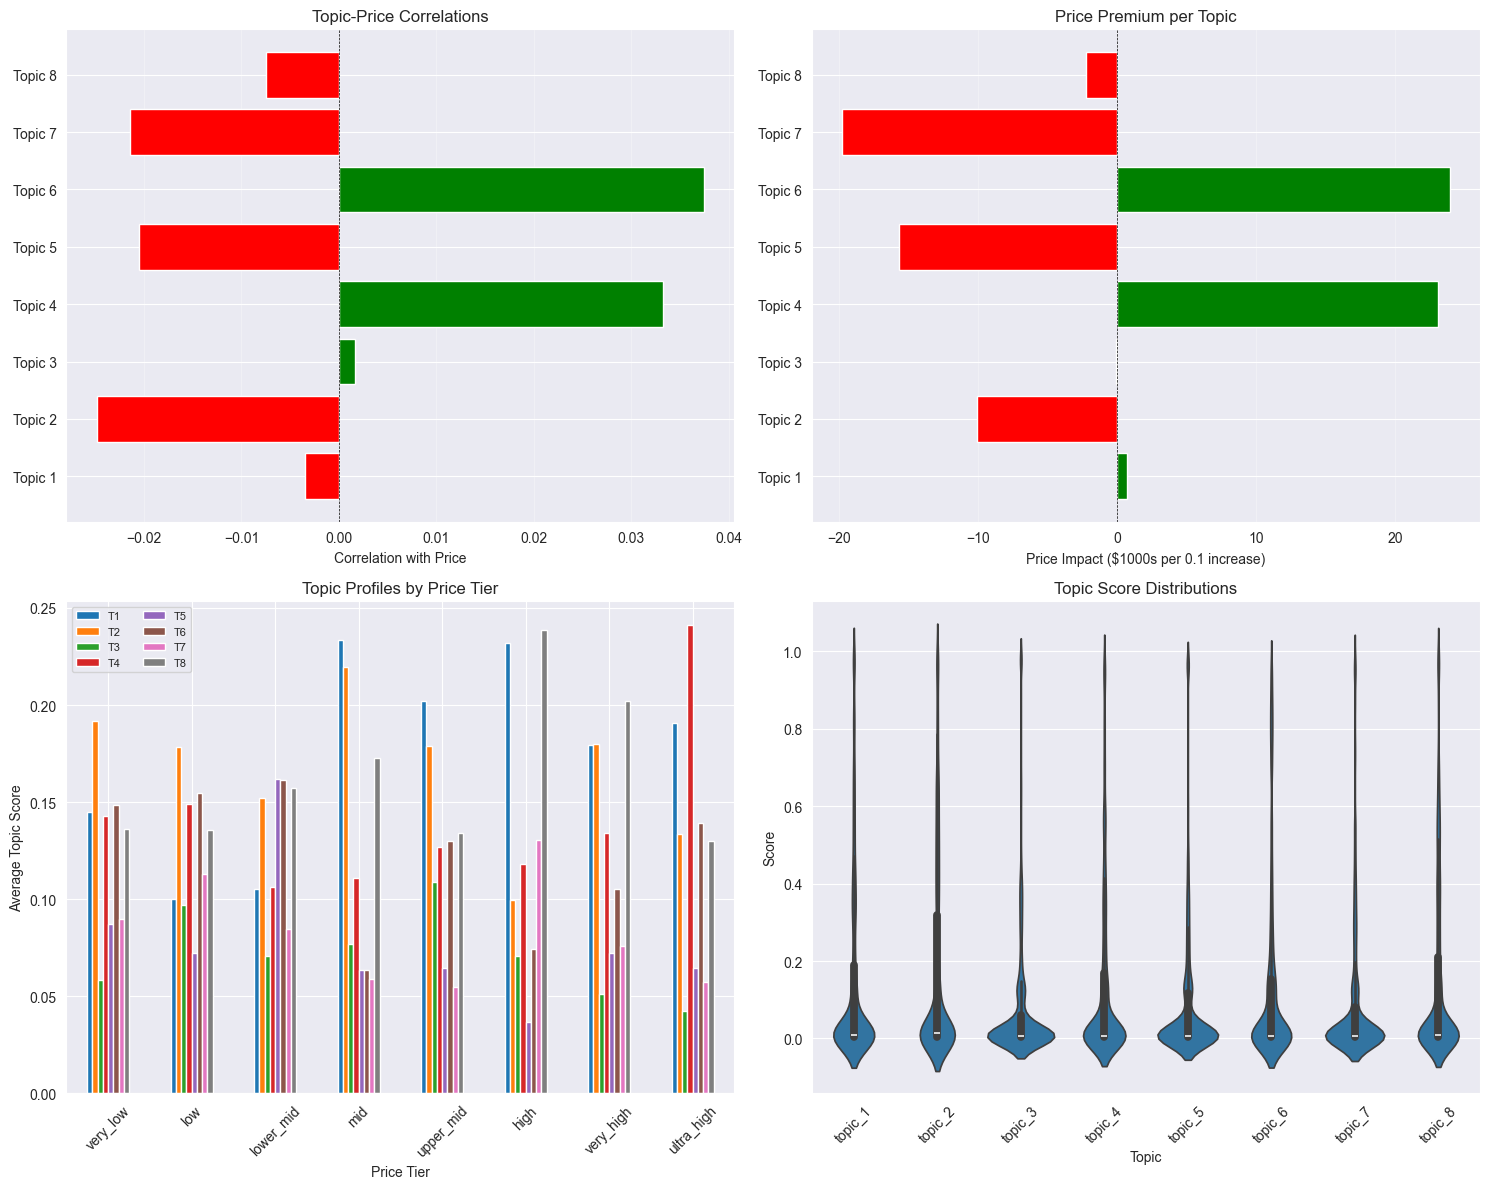


8. SAVING ANALYSIS RESULTS...
✓ Saved /Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs/topic_correlations.csv
✓ Saved /Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs/topic_premiums.csv
✓ Saved /Users/jenny.lin/BASIS_AVM_Onboarding/cate_scenario_analyses/model_outputs/topic_profiles_by_tier.csv

ANALYSIS COMPLETE

TO ANSWER YOUR COLLEAGUE:
  ✓ "Price per topic" → See topic_premiums.csv
  ✓ Topic correlations → See topic_correlations.csv
  ✓ Tier differences → See topic_profiles_by_tier.csv
  ✓ Visualizations → See topic_price_analysis.png


In [7]:
# ============================================================
# TOPIC-PRICE ANALYSIS
# Run this IMMEDIATELY AFTER the LDA training cell
# Uses the df with topics already added
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

print("="*70)
print("TOPIC-PRICE RELATIONSHIP ANALYSIS")
print("="*70)

# Get topic columns
topic_cols = [f'topic_{i+1}' for i in range(8)]

# Check if topics exist in dataframe
missing_topics = [col for col in topic_cols if col not in df.columns]
if missing_topics:
    print(f"\n❌ ERROR: Topics not found in dataframe!")
    print(f"Missing columns: {missing_topics}")
    print("\n" + "="*70)
    print("SOLUTION:")
    print("="*70)
    print("1. Go back and run the LDA training script (with image-only features)")
    print("2. That script will add topic_1 through topic_8 columns to 'df'")
    print("3. Then run THIS cell again")
    print("\nCannot proceed without topics. Stopping here.")
    print("="*70)
    # Don't continue - exit gracefully without crashing
    import sys
    if 'ipykernel' in sys.modules:
        # In Jupyter, just stop execution
        raise SystemExit("Topics not found - run LDA training first")
    else:
        sys.exit(1)

print(f"✓ Found all 8 topic columns in dataframe")
print(f"✓ Analyzing {len(df):,} properties")

# ============================================================
# 1. TOPIC-PRICE CORRELATIONS
# ============================================================
print("\n" + "="*70)
print("1. CORRELATION BETWEEN TOPICS AND PRICE")
print("="*70)

correlations = []
for i in range(8):
    topic_col = f'topic_{i+1}'
    corr = df[[topic_col, price_col]].corr().iloc[0, 1]
    correlations.append({'topic': i+1, 'correlation': corr})
    direction = "↑ Higher prices" if corr > 0 else "↓ Lower prices"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.15 else "Weak"
    print(f"Topic {i+1}: r = {corr:+.3f}  [{strength} {direction}]")

corr_df = pd.DataFrame(correlations)

# ============================================================
# 2. PRICE PREMIUM PER TOPIC (Linear Regression)
# ============================================================
print("\n" + "="*70)
print("2. PRICE PREMIUM PER 0.1 POINT INCREASE IN TOPIC SCORE")
print("="*70)

# Prepare data
X = df[topic_cols].fillna(0)
y = df[price_col]

# Fit linear model
lr = LinearRegression()
lr.fit(X, y)

print(f"\nModel R²: {lr.score(X, y):.3f}")
print("\nPrice Impact per Topic (per 0.1 increase in score):")
print("-"*70)

premiums = []
for i, coef in enumerate(lr.coef_):
    topic_num = i + 1
    premium = coef * 0.1
    premiums.append({'topic': topic_num, 'premium': premium})
    direction = "adds" if premium > 0 else "reduces"
    print(f"Topic {topic_num}: ${premium:>12,.0f}  ({direction} value)")

premium_df = pd.DataFrame(premiums)

# ============================================================
# 3. TOPIC INTERPRETATION (Top Features)
# ============================================================
print("\n" + "="*70)
print("3. WHAT EACH TOPIC REPRESENTS (Top 10 Visual Features)")
print("="*70)

try:
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx in range(8):
        topic = lda_model.components_[topic_idx]
        top_indices = topic.argsort()[-10:][::-1]
        top_features = [feature_names[i].replace('_', ' ') for i in top_indices]

        print(f"\nTopic {topic_idx + 1}:")
        print("  " + ", ".join(top_features))
except:
    print("⚠ Could not extract feature names (lda_model/vectorizer not in scope)")
    print("  Run this cell immediately after LDA training to see topic features")

# ============================================================
# 4. TOPIC PROFILES BY PRICE TIER
# ============================================================
print("\n" + "="*70)
print("4. AVERAGE TOPIC SCORES BY PRICE TIER")
print("="*70)

tier_profiles = []
for tier_name in ['very_low', 'low', 'lower_mid', 'mid', 'upper_mid', 'high', 'very_high', 'ultra_high']:
    tier_data = df[df['price_tier'] == tier_name]
    if len(tier_data) > 0:
        avg_topics = tier_data[topic_cols].mean()
        dominant_topic = avg_topics.idxmax()
        dominant_score = avg_topics.max()

        print(f"\n{tier_name} ({len(tier_data)} homes):")
        print(f"  Dominant: {dominant_topic} (score: {dominant_score:.3f})")
        print(f"  All topics: " + " | ".join([f"T{i+1}:{avg_topics.iloc[i]:.2f}" for i in range(8)]))

        tier_profiles.append({
            'tier': tier_name,
            'dominant_topic': dominant_topic,
            'dominant_score': dominant_score,
            **{f'topic_{i+1}': avg_topics.iloc[i] for i in range(8)}
        })

tier_df = pd.DataFrame(tier_profiles)

# ============================================================
# 5. SUMMARY STATISTICS
# ============================================================
print("\n" + "="*70)
print("5. TOPIC DISTRIBUTION SUMMARY")
print("="*70)

for i in range(8):
    topic_col = f'topic_{i+1}'
    stats = df[topic_col].describe()
    print(f"\nTopic {i+1}:")
    print(f"  Mean:   {stats['mean']:.3f}")
    print(f"  Median: {stats['50%']:.3f}")
    print(f"  Max:    {stats['max']:.3f}")
    print(f"  Homes with score > 0.3: {(df[topic_col] > 0.3).sum()} ({(df[topic_col] > 0.3).mean()*100:.1f}%)")

# ============================================================
# 6. KEY INSIGHTS
# ============================================================
print("\n" + "="*70)
print("6. KEY INSIGHTS")
print("="*70)

most_valuable = premium_df.loc[premium_df['premium'].idxmax()]
print(f"\n✓ Most Valuable Topic: Topic {int(most_valuable['topic'])} (+${most_valuable['premium']:,.0f} per 0.1 increase)")

strongest_corr = corr_df.loc[corr_df['correlation'].abs().idxmax()]
print(f"✓ Strongest Price Correlation: Topic {int(strongest_corr['topic'])} (r={strongest_corr['correlation']:.3f})")

if len(tier_df) > 0:
    if 'ultra_high' in tier_df['tier'].values and 'very_low' in tier_df['tier'].values:
        ultra = tier_df[tier_df['tier'] == 'ultra_high'].iloc[0]
        low = tier_df[tier_df['tier'] == 'very_low'].iloc[0]

        print(f"\n✓ Luxury vs Affordable Homes:")
        print(f"  Ultra-high homes dominated by: {ultra['dominant_topic']} (score: {ultra['dominant_score']:.3f})")
        print(f"  Very-low homes dominated by: {low['dominant_topic']} (score: {low['dominant_score']:.3f})")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
print("\n" + "="*70)
print("7. GENERATING VISUALIZATIONS...")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Topic-Price Correlations
axes[0, 0].barh(range(8), corr_df['correlation'], color=['red' if x < 0 else 'green' for x in corr_df['correlation']])
axes[0, 0].set_yticks(range(8))
axes[0, 0].set_yticklabels([f'Topic {i+1}' for i in range(8)])
axes[0, 0].set_xlabel('Correlation with Price')
axes[0, 0].set_title('Topic-Price Correlations')
axes[0, 0].axvline(x=0, color='black', linestyle='--', linewidth=0.5)
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Price Premium per Topic
axes[0, 1].barh(range(8), premium_df['premium']/1000, color=['red' if x < 0 else 'green' for x in premium_df['premium']])
axes[0, 1].set_yticks(range(8))
axes[0, 1].set_yticklabels([f'Topic {i+1}' for i in range(8)])
axes[0, 1].set_xlabel('Price Impact ($1000s per 0.1 increase)')
axes[0, 1].set_title('Price Premium per Topic')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=0.5)
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Topic Distribution by Tier
tier_order = ['very_low', 'low', 'lower_mid', 'mid', 'upper_mid', 'high', 'very_high', 'ultra_high']
tier_data_plot = tier_df.set_index('tier').reindex(tier_order)
topic_cols_plot = [f'topic_{i+1}' for i in range(8)]
tier_data_plot[topic_cols_plot].plot(kind='bar', stacked=False, ax=axes[1, 0], legend=False)
axes[1, 0].set_xlabel('Price Tier')
axes[1, 0].set_ylabel('Average Topic Score')
axes[1, 0].set_title('Topic Profiles by Price Tier')
axes[1, 0].legend([f'T{i+1}' for i in range(8)], loc='upper left', ncol=2, fontsize=8)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Topic Score Distributions
topic_data = df[topic_cols].melt(var_name='Topic', value_name='Score')
sns.violinplot(data=topic_data, x='Topic', y='Score', ax=axes[1, 1])
axes[1, 1].set_title('Topic Score Distributions')
axes[1, 1].set_xlabel('Topic')
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/topic_price_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved visualization to {OUTPUT_DIR}/topic_price_analysis.png")
plt.show()

# ============================================================
# 8. SAVE RESULTS
# ============================================================
print("\n" + "="*70)
print("8. SAVING ANALYSIS RESULTS...")
print("="*70)

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save correlation analysis
corr_df.to_csv(f'{OUTPUT_DIR}/topic_correlations.csv', index=False)
print(f"✓ Saved {OUTPUT_DIR}/topic_correlations.csv")

# Save premium analysis
premium_df.to_csv(f'{OUTPUT_DIR}/topic_premiums.csv', index=False)
print(f"✓ Saved {OUTPUT_DIR}/topic_premiums.csv")

# Save tier profiles
tier_df.to_csv(f'{OUTPUT_DIR}/topic_profiles_by_tier.csv', index=False)
print(f"✓ Saved {OUTPUT_DIR}/topic_profiles_by_tier.csv")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("\nTO ANSWER YOUR COLLEAGUE:")
print('  ✓ "Price per topic" → See topic_premiums.csv')
print('  ✓ Topic correlations → See topic_correlations.csv')
print('  ✓ Tier differences → See topic_profiles_by_tier.csv')
print('  ✓ Visualizations → See topic_price_analysis.png')

Overall: -4.80% degradation - NMF is actively hurting because XGBoost is fitting to 8 useless zero columns!